<a href="https://colab.research.google.com/github/ni-metre/Colab_Triplet_Loss_Backup/blob/master/Triple_Output_Copy_of_Colab_Quadruplet_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Set up gspread
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [2]:
% xmode verbose

Exception reporting mode: Verbose


In [4]:

#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Force a remount of the  drive
drive.mount("/content/drive", force_remount=True)

NameError: ignored

In [5]:
# import the necessary packages
import warnings

warnings.filterwarnings("ignore")


import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import numpy as np
import glob
import random

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()




import os
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten, Convolution1D, MaxPooling1D,ZeroPadding1D
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Add, Subtract
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from numpy import array
from sklearn.metrics import mean_squared_error


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE


import datetime
import math
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
#from Max_ML3 import prep_data, div_data, div_split_data, run_model, run_multi_model, run_experiment, concatenate_timeseries_and_static_features_list

import pickle
from tensorflow.keras.backend import sum as ksum
from tensorflow.keras.backend import square as ksquare
from tensorflow.keras.backend import mean as kmean
from tensorflow.keras.backend import maximum as kmaximum
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
import time



In [ ]:
from tensorflow.keras.losses import MeanSquaredError




## 0) Import Metadata

In [5]:
test_db_df=pd.read_csv('/content/drive/My Drive/Original_Fake_Test_Log.csv')
test_db_df.head()

,File,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,...,Area_to_Cal_int,Area_Pos_to_Cal_int,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old
0,10000.0,NaN,Combo of 3702 and 3388 | Weight - 0.44,10.0,44400.0,91.680,0.687500,NaN,NaN,38263.0,9.0,NaN,NaN,218.84,20.92,NaN,NaN,21.196,NaN,NaN,NaN,NaN,250.0,51289.0,27.694935,28.065920,NaN,-633.471028,2.322,1161.0,9.090,4545.0,60.213195,14.268,7134.0,NaN,NaN,-5567.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001.0,NaN,Combo of 3702 and 3388 | Weight - 0.17,10.0,41700.0,101.265,0.265625,NaN,NaN,38263.0,9.0,NaN,NaN,256.37,9.31,NaN,NaN,23.653,NaN,NaN,NaN,NaN,250.0,51289.0,28.442403,28.708275,NaN,-644.918818,2.252,1126.0,8.778,4389.0,60.899152,13.640,6820.0,NaN,NaN,-5468.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10002.0,NaN,Combo of 3702 and 3388 | Weight - 0.53,10.0,45300.0,88.485,0.828125,NaN,NaN,38263.0,9.0,NaN,NaN,206.33,24.79,NaN,NaN,20.377,NaN,NaN,NaN,NaN,250.0,51289.0,27.445779,27.851802,NaN,-629.889655,2.340,1170.0,9.190,4595.0,60.086085,14.314,7157.0,NaN,NaN,-5601.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10003.0,NaN,Combo of 3702 and 3388 | Weight - 0.4,10.0,44000.0,93.100,0.625000,NaN,NaN,38263.0,9.0,NaN,NaN,224.40,19.20,NaN,NaN,21.560,NaN,NaN,NaN,NaN,250.0,51289.0,27.805671,28.161084,NaN,-635.093230,2.306,1153.0,9.044,4522.0,60.273476,14.268,7134.0,NaN,NaN,-5552.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10004.0,NaN,Combo of 3702 and 3388 | Weight - 0.94,10.0,49400.0,73.930,1.468750,NaN,NaN,38263.0,9.0,NaN,NaN,149.34,42.42,NaN,NaN,16.646,NaN,NaN,NaN,NaN,250.0,51289.0,26.310735,26.876375,NaN,-615.034115,2.474,1237.0,9.620,4810.0,59.870634,14.674,7337.0,NaN,NaN,-5766.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#Convert to numeric to enable test sorting/picking
for column in test_db_df[['Acetone', 'CO2', 'H2O', 'Sensor', 'Test_that_day', 'Time_Btwn_s', 'Instr_Temp', 'Baseline', 'File', 'Total CO2']]:
    test_db_df[column] = pd.to_numeric(test_db_df[column])
test_db_df.set_index('File', inplace = True)
test_db_df.head()

,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,...,Area_to_Cal_int,Area_Pos_to_Cal_int,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000.0,NaN,Combo of 3702 and 3388 | Weight - 0.44,10.0,44400.0,91.680,0.687500,NaN,NaN,38263.0,9.0,NaN,NaN,218.84,20.92,NaN,NaN,21.196,NaN,NaN,NaN,NaN,250.0,51289.0,27.694935,28.065920,NaN,-633.471028,2.322,1161.0,9.090,4545.0,60.213195,14.268,7134.0,NaN,NaN,-5567.0,NaN,NaN,4640.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001.0,NaN,Combo of 3702 and 3388 | Weight - 0.17,10.0,41700.0,101.265,0.265625,NaN,NaN,38263.0,9.0,NaN,NaN,256.37,9.31,NaN,NaN,23.653,NaN,NaN,NaN,NaN,250.0,51289.0,28.442403,28.708275,NaN,-644.918818,2.252,1126.0,8.778,4389.0,60.899152,13.640,6820.0,NaN,NaN,-5468.0,NaN,NaN,4764.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002.0,NaN,Combo of 3702 and 3388 | Weight - 0.53,10.0,45300.0,88.485,0.828125,NaN,NaN,38263.0,9.0,NaN,NaN,206.33,24.79,NaN,NaN,20.377,NaN,NaN,NaN,NaN,250.0,51289.0,27.445779,27.851802,NaN,-629.889655,2.340,1170.0,9.190,4595.0,60.086085,14.314,7157.0,NaN,NaN,-5601.0,NaN,NaN,4616.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003.0,NaN,Combo of 3702 and 3388 | Weight - 0.4,10.0,44000.0,93.100,0.625000,NaN,NaN,38263.0,9.0,NaN,NaN,224.40,19.20,NaN,NaN,21.560,NaN,NaN,NaN,NaN,250.0,51289.0,27.805671,28.161084,NaN,-635.093230,2.306,1153.0,9.044,4522.0,60.273476,14.268,7134.0,NaN,NaN,-5552.0,NaN,NaN,4654.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004.0,NaN,Combo of 3702 and 3388 | Weight - 0.94,10.0,49400.0,73.930,1.468750,NaN,NaN,38263.0,9.0,NaN,NaN,149.34,42.42,NaN,NaN,16.646,NaN,NaN,NaN,NaN,250.0,51289.0,26.310735,26.876375,NaN,-615.034115,2.474,1237.0,9.620,4810.0,59.870634,14.674,7337.0,NaN,NaN,-5766.0,NaN,NaN,4458.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test_db_df.head(-1)

,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,...,Area_to_Cal_int,Area_Pos_to_Cal_int,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000.0,NaN,Combo of 3702 and 3388 | Weight - 0.44,10.0,44400.0,91.68000,0.687500,NaN,NaN,38263.0,9.0,NaN,NaN,218.84,20.92,NaN,NaN,21.1960,NaN,NaN,NaN,NaN,250.0,51289.0,27.694935,28.065920,NaN,-633.471028,2.322,1161.0,9.090,4545.0,60.213195,14.268,7134.0,NaN,NaN,-5567.0,NaN,NaN,4640.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001.0,NaN,Combo of 3702 and 3388 | Weight - 0.17,10.0,41700.0,101.26500,0.265625,NaN,NaN,38263.0,9.0,NaN,NaN,256.37,9.31,NaN,NaN,23.6530,NaN,NaN,NaN,NaN,250.0,51289.0,28.442403,28.708275,NaN,-644.918818,2.252,1126.0,8.778,4389.0,60.899152,13.640,6820.0,NaN,NaN,-5468.0,NaN,NaN,4764.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002.0,NaN,Combo of 3702 and 3388 | Weight - 0.53,10.0,45300.0,88.48500,0.828125,NaN,NaN,38263.0,9.0,NaN,NaN,206.33,24.79,NaN,NaN,20.3770,NaN,NaN,NaN,NaN,250.0,51289.0,27.445779,27.851802,NaN,-629.889655,2.340,1170.0,9.190,4595.0,60.086085,14.314,7157.0,NaN,NaN,-5601.0,NaN,NaN,4616.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003.0,NaN,Combo of 3702 and 3388 | Weight - 0.4,10.0,44000.0,93.10000,0.625000,NaN,NaN,38263.0,9.0,NaN,NaN,224.40,19.20,NaN,NaN,21.5600,NaN,NaN,NaN,NaN,250.0,51289.0,27.805671,28.161084,NaN,-635.093230,2.306,1153.0,9.044,4522.0,60.273476,14.268,7134.0,NaN,NaN,-5552.0,NaN,NaN,4654.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004.0,NaN,Combo of 3702 and 3388 | Weight - 0.94,10.0,49400.0,73.93000,1.468750,NaN,NaN,38263.0,9.0,NaN,NaN,149.34,42.42,NaN,NaN,16.6460,NaN,NaN,NaN,NaN,250.0,51289.0,26.310735,26.876375,NaN,-615.034115,2.474,1237.0,9.620,4810.0,59.870634,14.674,7337.0,NaN,NaN,-5766.0,NaN,NaN,4458.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037050.0,NaN,Combo of 4545 and 3577 | Weight - 0.51,10.0,45100.0,161.70424,1.593750,NaN,NaN,38107.0,10.0,NaN,NaN,268.82,25.28,NaN,NaN,27.7694,NaN,NaN,NaN,NaN,250.0,114212.0,25.873304,26.985748,NaN,-1043.879935,2.370,1185.0,9.592,4796.0,108.930113,15.248,7624.0,NaN,NaN,-9633.0,NaN,NaN,8421.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037051.0,NaN,Co

#### Below enter the path name of the test_output files

In [6]:
sensor_of_interest = 19

#path to fake data
path = '/content/drive/My Drive/Fakes_' + str(sensor_of_interest)

pickle_path = '/content/drive/My Drive/Pickles'
dev_pickle_path = '/content/drive/My Drive/Metre/Development/TFLite_Stuff/Pickles'
#If running in nicole
#path to model checkpoints
checkpoint_path = '/content/drive/My Drive/Checkpoints'

#path to real data
real_path = '/content/drive/My Drive/Test_outputs/General'

## 1) Defining the sets of 9 tests

#### **get_test_list** returns a list of tests that meet ALL of the criteria defined in the arguments:
#### - Acetone can be a specific value, 'all', '>(value)' or '<(value)'
#### -  CO2 can be 4 (for 40000 - 46666), 5 (for 46667 - 53333), 6 (for 53334 - 60000), 'all' or '+' for CO@ values that are > 0
#### - H2O must be a specific value, always 10 for tests of interest
#### - Sensor can be a specific sensor number or 'all'
#### - Range1 and Range2 are the lower and upper limits for the range of tests of interest from (range1) to (range2 - 1)




In [ ]:
def get_test_list (df, Acetone, CO2, H2O, Sensor, Range1, Range2):
    
    if Sensor == 'all':
        filtered = df
    else:
        filtered = df.query('Sensor == @Sensor')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            comp = float(Acetone[1:])
            filtered = filtered.query('Acetone < @comp')
        else:
            if str(Acetone)[:1] == '>':
                comp = float(Acetone[1:])
                filtered = filtered.query('Acetone > @comp')
            else:
                filtered = filtered.query('Acetone == @Acetone')
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered.query('CO2 != 0')
        else:
            if CO2 == 4:
                filtered = filtered.query('CO2 >= 40000 & CO2 <= 46666.67')
            else:
                if CO2 == 5:
                    filtered = filtered.query('CO2 > 46666.67 & CO2 <= 53333.33')
                else:
                    filtered = filtered.query('CO2 > 53333.33 & CO2 <= 60000')
    filtered = filtered.query('H2O == @H2O')
    filtered['Tests'] = filtered.index  
    list_of_tests = filtered['Tests'].tolist()
    return([y for y in list_of_tests if ((int(y)>=Range1)&(int(y)<Range2))])
    #return(filtered)

In [ ]:
test_set = get_test_list (test_db_df, '<25.1 ', '+', 10, 19, 600000, 905000)
print(len(test_set))

44292


In [ ]:
print(test_set[1])

800001.0


## IF YOU WANT TO READ FROM A PICKLED VERSION OF THE 1000 NONTETS (PREVIOUSLY GENERATED 08-07-2020) SKIP TO THE SECTION **"START HERE TO READ IN A PICKLE VERSION OF ttvdict!!!!!""**


#### Code here does the picking of the nonets based on the distances defined by **Ace_close, Ace_far, CO2_close, CO2_far, Temp_close,** and **Temp_far**

#### Acetone values range from 0 to 100 ppm, CO2 values range from 40000 to 60000 ppm, and temperature values range from about 7C to 39C.

In [ ]:

##### Make ML datasets for Acetone & CO2 & Temperature analysis -9 tests

c1_list = []
c2_list = []
c3_list = []
c4_list = []
c5_list = []
c6_list = []
c7_list = []
c8_list = []
c9_list = []
#Ace_close = 2 and Ace_far = 5 originally (with sensor 9 data)
Ace_close = 2
Ace_far = 5
CO2_close = 2000
CO2_far = 5000
Temp_close = 2
Temp_far = 5


##### You can set the number of 
for i in range(0,5000):
    print(i)
    #get a random test
    #get a random test
    A = random.choice(test_set)
    A_co = test_db_df.loc[A, 'CO2']
    A_ace = test_db_df.loc[A, 'Acetone']
    A_temp = test_db_df.loc[A, 'Instr_Temp']
    #pick a test with similar acetone and different CO2
    while True:
        B = random.choice(test_set)
        B_co = test_db_df.loc[B, 'CO2']
        B_ace = test_db_df.loc[B, 'Acetone']
        B_temp = test_db_df.loc[B, 'Instr_Temp']
        if ((abs(B_ace - A_ace) <= Ace_close) & 
            (abs(B_co - A_co) >= CO2_far) & 
            (abs(B_temp - A_temp) <= Temp_close)):
            break

    while True:
        C = random.choice(test_set)
        C_co = test_db_df.loc[C, 'CO2']
        C_ace = test_db_df.loc[C, 'Acetone']
        C_temp = test_db_df.loc[C, 'Instr_Temp']
    # Could add the following test below to avoid difficulty in picking a third CO2 test
    # (abs(A_co - C_co) <= (CO2_far + CO2_close))
        if ((abs(C_ace - A_ace) > Ace_far) & 
            (abs(C_co - A_co) >= CO2_far) & 
            (abs(C_co - B_co) >= CO2_far) &
            #(abs(A_co - C_co) <= (CO2_far + CO2_close))&
            (abs(C_temp - A_temp) <= Temp_close)):
            break

    while True:
        D = random.choice(test_set)
        D_co = test_db_df.loc[D, 'CO2']
        D_ace = test_db_df.loc[D, 'Acetone']
        D_temp = test_db_df.loc[D, 'Instr_Temp']
        if ((abs(D_ace - A_ace) > Ace_far) & 
          (abs(D_ace - C_ace) > Ace_far) & 
          (abs(D_co - C_co) < CO2_close) & 
          (abs(D_temp - A_temp) <= Temp_close)):
          break

    while True:
        E = random.choice(test_set)
        E_co = test_db_df.loc[E, 'CO2']
        E_ace = test_db_df.loc[E, 'Acetone']
        E_temp = test_db_df.loc[E, 'Instr_Temp']
        if ((abs(E_ace - A_ace) > Ace_far) & 
            (abs(E_co - A_co) < CO2_close) & 
            (abs(E_temp - A_temp) <= Temp_close)):
            break

    while True:
        F = random.choice(test_set)
        F_co = test_db_df.loc[F, 'CO2']
        F_ace = test_db_df.loc[F, 'Acetone']
        F_temp = test_db_df.loc[F, 'Instr_Temp']
        if ((abs(F_ace - A_ace) > Ace_far) & 
            (abs(F_ace - E_ace) > Ace_far) & 
            (abs(F_co - A_co) < CO2_close) & 
            (abs(F_temp - A_temp) > Temp_far)):
            break

    while True:
        G = random.choice(test_set)
        G_co = test_db_df.loc[G, 'CO2']
        G_ace = test_db_df.loc[G, 'Acetone']
        G_temp = test_db_df.loc[G, 'Instr_Temp']
        if ((abs(G_ace - A_ace) <= Ace_close) & 
            (abs(G_co - A_co) >= CO2_far) & 
            (abs(G_co - B_co) >= CO2_far) &
            (abs(G_temp - A_temp) > Temp_far)):
            break

    while True:
        H = random.choice(test_set)
        H_co = test_db_df.loc[H, 'CO2']
        H_ace = test_db_df.loc[H, 'Acetone']
        H_temp = test_db_df.loc[H, 'Instr_Temp']
        if ((H != A) & 
            (abs(H_ace - A_ace) <= Ace_close) & 
            (abs(H_co - A_co) < CO2_close) & 
            (abs(H_temp - A_temp) <= Temp_close)):
            break

    while True:
        I = random.choice(test_set)
        I_co = test_db_df.loc[I, 'CO2']
        I_ace = test_db_df.loc[I, 'Acetone']
        I_temp = test_db_df.loc[I, 'Instr_Temp']
        if ((abs(I_ace - A_ace) <= Ace_close) & 
            (abs(I_co - A_co) < CO2_close) & 
            (abs(I_temp - A_temp) > Temp_far)):
            break
    c1_list.append(A)
    c2_list.append(B)
    c3_list.append(C)
    c4_list.append(D)
    c5_list.append(E)
    c6_list.append(F)
    c7_list.append(G)
    c8_list.append(H)
    c9_list.append(I)

In [ ]:
#Turn lists into dictionary
cdict = {'c1_list': c1_list, 'c2_list': c2_list, 'c3_list': c3_list, 'c4_list': c4_list, 'c5_list': c5_list, 'c6_list': c6_list, 'c7_list': c7_list, 'c8_list': c8_list,'c9_list': c9_list}

## 2) Reading in and preprocessing the data

#### Code below reads in csvs (signal data), acetone, co2 , and temperature data for each test in the 9 groups.

#### In this code, CO2 values are scaled by 2000 so they are within the same range as the acetone values. There is an option to change this scaling factor below (see **RESCALE DATA**)

In [ ]:
#with open(pickle_path +'/cdict_15_metadata_10000.pickle', 'rb') as handle:
    
 #   cdict = pickle.load(handle)


In [ ]:
#This usually takes 60 - 90 minutes to run 1000 nonets

scale = 1
cut_off_time =30

testdict = defaultdict(list)
Acdict =defaultdict(list)
co2dict = defaultdict(list)
tempdict = defaultdict(list)
metadatadict = defaultdict(list)


for i in range(1, len(cdict)+1):
    print(i)
    test_list = []
    Ac_list = []
    co2_list = []
    temp_list = []
    metadata_list = []
    for j in cdict['c' + str(i) + '_list']:
            ac = float(test_db_df.loc[j, 'Acetone'])
            co2 = int(test_db_df.loc[j, 'CO2'])/2000
            temp = float(test_db_df.loc[j, 'Instr_Temp'])
            sample_rate = int(test_db_df.loc[j, 'Sample_rate'])
            num_of_samples = int(cut_off_time*sample_rate/scale)
            bs = float(test_db_df.loc[j, 'Baseline'])
            timebtwn = float(test_db_df.loc[j, 'Time_Btwn_s'])
            totalco2 = float(test_db_df.loc[j, 'Total CO2'])
            testday = float(test_db_df.loc[j, 'Test_that_day'])

        
            full_data = pd.read_csv(path+ '/test_output' + str(int(j)) + '.csv',header = 0)
            sig_data = full_data[['Second','mV_rolling_mean']].truncate(after = cut_off_time*sample_rate-1)
            mV_data = sig_data['mV_rolling_mean'].to_numpy()
            mV_data[np.isnan(mV_data)]=0
            # All the fake data is currently at 250 Hz so no recasting of the data is needed       
            #if sample_rate == 500:
            #    mV_data = mV_data.reshape(-1, 2).mean(axis=1)
           
            test_list.append(mV_data)
            Ac_list.append(ac)
            co2_list.append(co2)
            temp_list.append(temp)
            metadata_list.append([temp, bs, timebtwn, totalco2, testday])
    testdict['c' + str(i)+'tests'] = np.array(test_list)
    Acdict['c' + str(i) + 'Ac']= np.array(Ac_list)
    co2dict['c' + str(i) + 'co2']= np.array(co2_list)
    tempdict['c' + str(i) + 'temp']= np.array(temp_list)
    metadatadict['c' + str(i)+'metadata'] = np.array(metadata_list)

    

In [ ]:


print(len(metadatadict['c8metadata']))

5000


In [ ]:
foo = pd.read_csv('/content/drive/My Drive/Fakes_19/test_output800061.csv')
print(foo)

FileNotFoundError: ignored

#### Tuns lists into arrays and front-zero-pads the csvs (signal data) so that the csvs are all the same length

In [ ]:
#Check for the csv with the longest length
lengths = []
for i in range(0, len(testdict['c1tests'])-1):
    for j in range(1,5):
        lengths.append(len(testdict['c' +str(j)+'tests'][i]))

maxlen = max(lengths)
print(maxlen)

7500


In [ ]:
#Front pad the csvs so they are the same length as the longest csv (maxlen)
#Turn lists into arrays

paddict= defaultdict(list)
for i in range(1, len(cdict)+1):
    paddict['paddedc' + str(i)] = pad_sequences(testdict['c' +str(i) + 'tests'], maxlen = maxlen)
    print(paddict['paddedc'+str(i)].shape)


(5000, 7500)
(5000, 7500)
(5000, 7500)
(5000, 7500)
(5000, 7500)
(5000, 7500)
(5000, 7500)
(5000, 7500)
(0, 7500)


In [ ]:
# Combine everything to a dictionary
ttvdict = dict(paddict, **Acdict)
ttvdict.update(co2dict)
ttvdict.update(tempdict)
ttvdict.update(metadatadict)

indict = {'indices': range(len(ttvdict['paddedc1']))}
ttvdict.update(indict)
print(ttvdict.keys())
print(len(ttvdict))

dict_keys(['paddedc1', 'paddedc2', 'paddedc3', 'paddedc4', 'paddedc5', 'paddedc6', 'paddedc7', 'paddedc8', 'paddedc9', 'c1Ac', 'c2Ac', 'c3Ac', 'c4Ac', 'c5Ac', 'c6Ac', 'c7Ac', 'c8Ac', 'c1co2', 'c2co2', 'c3co2', 'c4co2', 'c5co2', 'c6co2', 'c7co2', 'c8co2', 'c1temp', 'c2temp', 'c3temp', 'c4temp', 'c5temp', 'c6temp', 'c7temp', 'c8temp', 'c8_list', 'c1metadata', 'c2metadata', 'c3metadata', 'c4metadata', 'c5metadata', 'c6metadata', 'c7metadata', 'c8metadata', 'c9_list', 'c9metadata', 'indices'])
45


In [ ]:
# To save ttvdict as a pickle
#You have ttvdict_15_metadata_2638.pickle



with open(pickle_path +'/ttvdict_16_metadata_5000_30s.pickle', 'wb') as handle:
    pickle.dump(ttvdict, handle, protocol=pickle.HIGHEST_PROTOCOL)



## Temporary code to construct pickles with sensor embeddings created by classifer

In [ ]:
with open(pickle_path +'/ttvdict_19_metadata_5000_30s.pickle', 'rb') as handle:
    
    ttvdict_19 = pickle.load(handle)
#cdict_19 = {'c1_list': ttvdict['paddedc1'], 'c2_list': ttvdict['paddedc2'], 'c3_list': ttvdict['paddedc3'], 'c4_list': ttvdict['paddedc4'], 'c5_list': ttvdict['paddedc5'], 'c6_list': ttvdict['paddedc6'], 'c7_list': ttvdict['paddedc7'], 'c8_list': ttvdict['paddedc8'],'c9_list': ttvdict['paddedc9']}

In [ ]:
with open(pickle_path +'/ttvdict_16_metadata_5000_30s.pickle', 'rb') as handle:
    
    ttvdict_16 = pickle.load(handle)
#cdict_16 = {'c1_list': ttvdict['paddedc1'], 'c2_list': ttvdict['paddedc2'], 'c3_list': ttvdict['paddedc3'], 'c4_list': ttvdict['paddedc4'], 'c5_list': ttvdict['paddedc5'], 'c6_list': ttvdict['paddedc6'], 'c7_list': ttvdict['paddedc7'], 'c8_list': ttvdict['paddedc8'],'c9_list': ttvdict['paddedc9']}

In [ ]:
with open(pickle_path +'/ttvdict_15_metadata_5000_30s.pickle', 'rb') as handle:
    
    ttvdict_15 = pickle.load(handle)
#cdict_15 = {'c1_list': ttvdict['paddedc1'], 'c2_list': ttvdict['paddedc2'], 'c3_list': ttvdict['paddedc3'], 'c4_list': ttvdict['paddedc4'], 'c5_list': ttvdict['paddedc5'], 'c6_list': ttvdict['paddedc6'], 'c7_list': ttvdict['paddedc7'], 'c8_list': ttvdict['paddedc8'],'c9_list': ttvdict['paddedc9']}

In [ ]:
with open(pickle_path +'/ttvdict_14_metadata_5000_30s.pickle', 'rb') as handle:
    
    ttvdict_14 = pickle.load(handle)
#cdict_14 = {'c1_list': ttvdict['paddedc1'], 'c2_list': ttvdict['paddedc2'], 'c3_list': ttvdict['paddedc3'], 'c4_list': ttvdict['paddedc4'], 'c5_list': ttvdict['paddedc5'], 'c6_list': ttvdict['paddedc6'], 'c7_list': ttvdict['paddedc7'], 'c8_list': ttvdict['paddedc8'],'c9_list': ttvdict['paddedc9']}

In [ ]:
with open(pickle_path +'/ttvdict_10_metadata_5000_30s.pickle', 'rb') as handle:
    
    ttvdict_10 = pickle.load(handle)

In [ ]:
with open(pickle_path +'/ttvdict_09_metadata_5000_30s.pickle', 'rb') as handle:
    
    ttvdict_09 = pickle.load(handle)
#cdict_09 = {'c1_list': ttvdict['paddedc1'], 'c2_list': ttvdict['paddedc2'], 'c3_list': ttvdict['paddedc3'], 'c4_list': ttvdict['paddedc4'], 'c5_list': ttvdict['paddedc5'], 'c6_list': ttvdict['paddedc6'], 'c7_list': ttvdict['paddedc7'], 'c8_list': ttvdict['paddedc8'],'c9_list': ttvdict['paddedc9']}

In [ ]:



with open(pickle_path + '/avg_embeddings_from_real_data_all_sensors.pickle', 'rb') as handle:
  avg_embedding_dict = pickle.load(handle)
print(avg_embedding_dict.keys())

dict_keys(['Real data for 19', 'Real data for 18', 'Real data for 16', 'Real data for 15', 'Real data for 14', 'Real data for 10', 'Real data for 9', 'Predicted Real data for 16', 'Predicted Real data for 16_12Ar2', 'Predicted Real data for 16_12B', '12ATrain Real data for 16_12A', '12BTrain Real data for 16_12B', '18ATrain Real data for 16_18A', '18BTrain Real data for 16_18B', '36ATrain Real data for 16_36A', '30ATrain Real data for 16_30A', 'Train Real data for 16_w_ratio_E1', 'Train Real data for 19_w_ratio_E1', 'Train Real data for 15_w_ratio_E1', 'Train Real data for 14_w_ratio_E1', 'Train Real data for 10_w_ratio_E1', 'Train Real data for 9_w_ratio_E1', 'Train Real data for 9_w_ratio_E1_noratio', 'Train Real data for 10_w_ratio_E1_noratio', 'Train Real data for 14_w_ratio_E1_noratio', 'Train Real data for 15_w_ratio_E1_noratio', 'Train Real data for 16_w_ratio_E1_noratio', 'Train Real data for 19_w_ratio_E1_noratio'])


This will be the code to remove stuff from pickles

In [ ]:
del ttvdict_19['indices']
del ttvdict_16['indices']
del ttvdict_15['indices']
del ttvdict_14['indices']
del ttvdict_10['indices']
del ttvdict_09['indices']


In [ ]:
# Don't run this if you want to get all 5000
for d in (ttvdict_19, ttvdict_16,ttvdict_15, ttvdict_14, ttvdict_10, ttvdict_09 ): # you can list as many input dicts as you want here
    for key, value in d.items():
        d[key] = (value[0:2500])

In [ ]:
print(avg_embedding_dict.keys())

dict_keys(['Real data for 19', 'Real data for 18', 'Real data for 16', 'Real data for 15', 'Real data for 14', 'Real data for 10', 'Real data for 9', 'Predicted Real data for 16', 'Predicted Real data for 16_12Ar2', 'Predicted Real data for 16_12B', '12ATrain Real data for 16_12A', '12BTrain Real data for 16_12B', '18ATrain Real data for 16_18A', '18BTrain Real data for 16_18B', '36ATrain Real data for 16_36A', '30ATrain Real data for 16_30A'])


In [ ]:
print(ttvdict_19.keys())

dict_keys(['paddedc1', 'paddedc2', 'paddedc3', 'paddedc4', 'paddedc5', 'paddedc6', 'paddedc7', 'paddedc8', 'paddedc9', 'c1Ac', 'c2Ac', 'c3Ac', 'c4Ac', 'c5Ac', 'c6Ac', 'c7Ac', 'c8Ac', 'c9Ac', 'c1co2', 'c2co2', 'c3co2', 'c4co2', 'c5co2', 'c6co2', 'c7co2', 'c8co2', 'c9co2', 'c1temp', 'c2temp', 'c3temp', 'c4temp', 'c5temp', 'c6temp', 'c7temp', 'c8temp', 'c9temp', 'c1metadata', 'c2metadata', 'c3metadata', 'c4metadata', 'c5metadata', 'c6metadata', 'c7metadata', 'c8metadata', 'c9metadata'])


In [ ]:
list19 = []
list16 = []
list15 = []
list14 = []
list10 = []
list09 = []


for i in range(0,2500):
    list19.append(avg_embedding_dict['Train Real data for 19_w_ratio_E1_noratio'])

    list16.append(avg_embedding_dict['Train Real data for 16_w_ratio_E1_noratio'])

    list15.append(avg_embedding_dict['Train Real data for 15_w_ratio_E1_noratio'])

    list14.append(avg_embedding_dict['Train Real data for 14_w_ratio_E1_noratio'])

    list10.append(avg_embedding_dict['Train Real data for 10_w_ratio_E1_noratio'])

    list09.append(avg_embedding_dict['Train Real data for 9_w_ratio_E1_noratio'])


In [ ]:
for i in range (1,10):
  ttvdict_19['c'+ str(i) + 'sensor'] = list19
  ttvdict_16['c'+ str(i) + 'sensor'] = list16
  ttvdict_15['c'+ str(i) + 'sensor'] = list15
  ttvdict_14['c'+ str(i) + 'sensor'] = list14
  ttvdict_10['c'+ str(i) + 'sensor'] = list10
  ttvdict_09['c'+ str(i) + 'sensor'] = list09




In [ ]:
print(len(ttvdict_10['c1sensor']))
print(ttvdict_10.keys())

2500
dict_keys(['paddedc1', 'paddedc2', 'paddedc3', 'paddedc4', 'paddedc5', 'paddedc6', 'paddedc7', 'paddedc8', 'paddedc9', 'c1Ac', 'c2Ac', 'c3Ac', 'c4Ac', 'c5Ac', 'c6Ac', 'c7Ac', 'c8Ac', 'c9Ac', 'c1co2', 'c2co2', 'c3co2', 'c4co2', 'c5co2', 'c6co2', 'c7co2', 'c8co2', 'c9co2', 'c1temp', 'c2temp', 'c3temp', 'c4temp', 'c5temp', 'c6temp', 'c7temp', 'c8temp', 'c9temp', 'c1metadata', 'c2metadata', 'c3metadata', 'c4metadata', 'c5metadata', 'c6metadata', 'c7metadata', 'c8metadata', 'c9metadata', 'c1sensor', 'c2sensor', 'c3sensor', 'c4sensor', 'c5sensor', 'c6sensor', 'c7sensor', 'c8sensor', 'c9sensor', 'indices'])


In [ ]:
#del ttvdict_19['indices']
#del ttvdict_16['indices']
#del ttvdict_15['indices']
#del ttvdict_14['indices']
#del ttvdict_09['indices']

ttvdict_19['indices'] = range(len(ttvdict_19['paddedc1']))
ttvdict_16['indices'] = range(len(ttvdict_19['paddedc1']))
ttvdict_15['indices'] = range(len(ttvdict_19['paddedc1']))
ttvdict_14['indices'] = range(len(ttvdict_19['paddedc1']))
ttvdict_10['indices'] = range(len(ttvdict_19['paddedc1']))
ttvdict_09['indices'] = range(len(ttvdict_19['paddedc1']))

In [ ]:
print(avg_embedding_dict['Real data for 10'])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.89768337e-02 4.03867424e-01 3.73050995e+01 0.00000000e+00
 0.00000000e+00 1.35665759e-01 0.00000000e+00 0.00000000e+00
 1.31460583e+00 1.10555805e-01 2.45994911e+01 6.31721992e+01
 7.45738924e-01 9.96279049e+00 8.04747999e-01 7.16055185e-02
 1.99936867e+01 3.94893742e+00 5.52924633e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.46197752e-03 0.00000000e+00
 4.35292282e+01 3.91888690e+00 8.89807606e+00 3.95824280e+01]


In [ ]:
ttvdict_combine = defaultdict(list)

for d in (ttvdict_19, ttvdict_15, ttvdict_14, ttvdict_10, ttvdict_09 ): # you can list as many input dicts as you want here
    for key, value in d.items():
        ttvdict_combine[key].extend(value)



In [ ]:
print(len(ttvdict_combine['c9sensor']))

12500


In [ ]:
# To save ttvdict as a pickle
#You have ttvdict_15_metadata_2638.pickle



with open(pickle_path +'/ttvdict_sensor_metadata_2500ea_19_no_16_15_14_10_09_ratio_embeddingsE1_noratio.pickle', 'wb') as handle:
    pickle.dump(ttvdict_combine, handle, protocol=pickle.HIGHEST_PROTOCOL)

# **START HERE TO READ IN A PICKLE VERSION OF ttvdict**!!!!! 

In [54]:
#with open(pickle_path +'/ttvdict_sensor_metadata_2500ea_19_no16_15_14_10_09.pickle', 'rb') as handle:
with open(pickle_path +'/ttvdict_sensor_metadata_2500ea_19_16_15_14_10_09_ratio_embeddingsE1.pickle', 'rb') as handle:
    
    ttvdict = pickle.load(handle)
cdict = {'c1_list': ttvdict['paddedc1'], 'c2_list': ttvdict['paddedc2'], 'c3_list': ttvdict['paddedc3'], 'c4_list': ttvdict['paddedc4'], 'c5_list': ttvdict['paddedc5'], 'c6_list': ttvdict['paddedc6'], 'c7_list': ttvdict['paddedc7'], 'c8_list': ttvdict['paddedc8'],'c9_list': ttvdict['paddedc9']}

In [55]:
#Function to unpack dictionary to list
def unpack_dict(ttvdict):
    vlist = []
    for k,v in ttvdict.items():
        vlist.append(ttvdict[k] )
    return vlist

vlist = unpack_dict(ttvdict)
print(ttvdict.keys())

dict_keys(['paddedc1', 'paddedc2', 'paddedc3', 'paddedc4', 'paddedc5', 'paddedc6', 'paddedc7', 'paddedc8', 'paddedc9', 'c1Ac', 'c2Ac', 'c3Ac', 'c4Ac', 'c5Ac', 'c6Ac', 'c7Ac', 'c8Ac', 'c9Ac', 'c1co2', 'c2co2', 'c3co2', 'c4co2', 'c5co2', 'c6co2', 'c7co2', 'c8co2', 'c9co2', 'c1temp', 'c2temp', 'c3temp', 'c4temp', 'c5temp', 'c6temp', 'c7temp', 'c8temp', 'c9temp', 'c1metadata', 'c2metadata', 'c3metadata', 'c4metadata', 'c5metadata', 'c6metadata', 'c7metadata', 'c8metadata', 'c9metadata', 'c1sensor', 'c2sensor', 'c3sensor', 'c4sensor', 'c5sensor', 'c6sensor', 'c7sensor', 'c8sensor', 'c9sensor', 'indices'])


In [ ]:
print(len(ttvdict['c1sensor']))

15000


#### Splits data into training, validation, and test sets

In [56]:
#Splits the data into training, validation, and test lits

tvt= train_test_split(*vlist,test_size =0.25)
print(len(tvt))

train_list = tvt[::2]
val_and_test_list = tvt[1::2]
print(len(val_and_test_list))

vt = train_test_split(*val_and_test_list,test_size =0.5)

val_list = vt[::2]
test_list = vt[1::2]
print(len(test_list))

110
55
55


In [57]:
# Assigns test, train, validation data to appropriate dictionary; preps X input data to appropriate shape for 1D convolutions


X_test_dict = defaultdict(list)
X_train_dict = defaultdict(list)
X_val_dict = defaultdict(list)

X_meta_test_dict = defaultdict(list)
X_meta_train_dict = defaultdict(list)
X_meta_val_dict = defaultdict(list)


X_sensor_test_dict = defaultdict(list)
X_sensor_train_dict = defaultdict(list)
X_sensor_val_dict = defaultdict(list)

Y_a_train_dict = defaultdict(list)
Y_c_train_dict = defaultdict(list)
Y_t_train_dict = defaultdict(list)


Y_a_val_dict = defaultdict(list)
Y_c_val_dict = defaultdict(list)
Y_t_val_dict = defaultdict(list)


Y_a_test_dict = defaultdict(list)
Y_c_test_dict = defaultdict(list)
Y_t_test_dict = defaultdict(list)


for i in range(0, len(cdict)):
    subi = i +1
    
    
    X_train_dict['X_c' + str(subi)+ '_train'] = np.squeeze(train_list[i])[...,np.newaxis]
    X_val_dict['X_c' + str(subi)+ '_val'] = np.squeeze(val_list[i])[...,np.newaxis]
    X_test_dict['X_c' + str(subi)+ '_test'] = np.squeeze(test_list[i])[...,np.newaxis]
    
    X_meta_train_dict['X_c' + str(subi)+ '_m_train'] = np.array(train_list[i + 4*len(cdict)])
    X_meta_val_dict['X_c' + str(subi)+ '_m_val'] = np.array(val_list[i + 4*len(cdict)])
    X_meta_test_dict['X_c' + str(subi)+ '_m_test'] = np.array(test_list[i + 4*len(cdict)])

    X_sensor_train_dict['X_c' + str(subi)+ '_s_train'] = np.array(train_list[i + 5*len(cdict)])
    X_sensor_val_dict['X_c' + str(subi)+ '_s_val'] = np.array(val_list[i + 5*len(cdict)])
    X_sensor_test_dict['X_c' + str(subi)+ '_s_test'] = np.array(test_list[i + 5*len(cdict)])

    Y_a_train_dict['Y_c' + str(subi)+ '_a_train']= np.array(train_list[i + len(cdict)])
    Y_c_train_dict['Y_c' + str(subi)+ '_c_train'] = np.array(train_list[i + 2*len(cdict)])
    Y_t_train_dict['Y_c' + str(subi)+ '_t_train'] = np.array(train_list[i + 3*len(cdict)])

    Y_a_val_dict['Y_c' + str(subi)+ '_a_val']= np.array(val_list[i + len(cdict)])
    Y_c_val_dict['Y_c' + str(subi)+ '_c_val'] = np.array(val_list[i + 2*len(cdict)])
    Y_t_val_dict['Y_c' + str(subi)+ '_t_val'] = np.array(val_list[i + 3*len(cdict)])

    Y_a_test_dict['Y_c' + str(subi)+ '_a_test']= np.array(test_list[i + len(cdict)])
    Y_c_test_dict['Y_c' + str(subi)+ '_c_test'] = np.array(test_list[i + 2*len(cdict)])
    Y_t_test_dict['Y_c' + str(subi)+ '_t_test'] = np.array(test_list[i + 3*len(cdict)])


    #Y_bs_train_dict['Y_c' + str(subi)+ '_bs_train'] = train_list[i + 4*len(cdict)]
    #Y_tb_train_dict['Y_c' + str(subi)+ '_tb_train'] = train_list[i + 5*len(cdict)]
    #Y_tco2_train_dict['Y_c' + str(subi)+ '_tco2_train'] = train_list[i + 6*len(cdict)]
    #Y_ttd_train_dict['Y_c' + str(subi)+ '_ttd_train'] = train_list[i + 7*len(cdict)]
    




    
    

    print(i)
    print(X_test_dict['X_c' + str(subi)+ '_test'].shape)
    print(X_train_dict['X_c' + str(subi)+ '_train'].shape)
    print(X_val_dict['X_c' + str(subi)+ '_val'].shape)
    print(len(Y_c_train_dict['Y_c' + str(subi)+ '_c_train']))
    print(len(Y_a_test_dict['Y_c' + str(subi)+ '_a_test']))
    print(len(Y_t_test_dict['Y_c' + str(subi)+ '_t_test']))
    print('metadata')
    print(len(X_meta_test_dict['X_c' + str(subi)+ '_m_test']))
    print(X_meta_train_dict['X_c' + str(subi)+ '_m_train'].shape)




0
(1875, 7500, 1)
(11250, 7500, 1)
(1875, 7500, 1)
11250
1875
1875
metadata
1875
(11250, 5)
1
(1875, 7500, 1)
(11250, 7500, 1)
(1875, 7500, 1)
11250
1875
1875
metadata
1875
(11250, 5)
2
(1875, 7500, 1)
(11250, 7500, 1)
(1875, 7500, 1)
11250
1875
1875
metadata
1875
(11250, 5)
3
(1875, 7500, 1)
(11250, 7500, 1)
(1875, 7500, 1)
11250
1875
1875
metadata
1875
(11250, 5)
4
(1875, 7500, 1)
(11250, 7500, 1)
(1875, 7500, 1)
11250
1875
1875
metadata
1875
(11250, 5)
5
(1875, 7500, 1)
(11250, 7500, 1)
(1875, 7500, 1)
11250
1875
1875
metadata
1875
(11250, 5)
6
(1875, 7500, 1)
(11250, 7500, 1)
(1875, 7500, 1)
11250
1875
1875
metadata
1875
(11250, 5)
7
(1875, 7500, 1)
(11250, 7500, 1)
(1875, 7500, 1)
11250
1875
1875
metadata
1875
(11250, 5)
8
(1875, 7500, 1)
(11250, 7500, 1)
(1875, 7500, 1)
11250
1875
1875
metadata
1875
(11250, 5)


### **RESCALE DATA**
#### If you'd like to rescale the CO2 data (it's currently divided by 2000), change **scale_factor** from 1 to another number (i.e. changing **scale_factor** to 2 will mean the CO2 data will now be scaled to 1/1000 it's real-life, 40000-60000 ppm, values instead of 1/2000 its real-life value). 
#### From my preliminary testing, I've found that increasing the scale_factor decreases the accuracy of the acetone predictions without much improvement to the CO2 predictions

### Even if you do not want to adjust the scale of the pre-scaled-CO2 data, **run this cell anyway** with a scale_factor of 1 since the rest of the notebook will make reference to **Y_cn** dictionaries defined below.

In [58]:
scale_factor = 1


Y_cn_train_dict = defaultdict(list)
Y_cn_test_dict =defaultdict(list)
Y_cn_val_dict = defaultdict(list)

for i in range(0, len(Y_c_train_dict)):
  subi = i + 1
  cn_train_list = []
  for j in range (0, len(Y_c_train_dict['Y_c' + str(subi)+ '_c_train'])):
    cn_train = (Y_c_train_dict['Y_c' + str(subi)+ '_c_train'][j])*scale_factor
    cn_train_list.append(cn_train)
  Y_cn_train_dict['Y_c' + str(subi)+ '_c_train'] = np.array(cn_train_list)


for i in range(0, len(Y_c_test_dict)):
  subi = i + 1
  cn_test_list = []
  for j in range (0, len(Y_c_test_dict['Y_c' + str(subi)+ '_c_test'])):
    cn_test = (Y_c_test_dict['Y_c' + str(subi)+ '_c_test'][j]*scale_factor)
    cn_test_list.append(cn_test)
  Y_cn_test_dict['Y_c' + str(subi)+ '_c_test'] = np.array(cn_test_list)


for i in range(0, len(Y_c_val_dict)):
  subi = i + 1
  cn_val_list = []
  for j in range (0, len(Y_c_val_dict['Y_c' + str(subi)+ '_c_val'])):
    cn_val = (Y_c_val_dict['Y_c' + str(subi)+ '_c_val'][j]*scale_factor)
    cn_val_list.append(cn_val)
  Y_cn_val_dict['Y_c' + str(subi)+ '_c_val'] = np.array(cn_val_list)

In [ ]:
print(Y_cn_train_dict.keys())

dict_keys(['Y_c1_c_train', 'Y_c2_c_train', 'Y_c3_c_train', 'Y_c4_c_train', 'Y_c5_c_train', 'Y_c6_c_train', 'Y_c7_c_train', 'Y_c8_c_train', 'Y_c9_c_train'])


In [ ]:
#Sanity check to verify the scaling
print(Y_cn_train_dict['Y_c9_c_train'])

[20.9  25.   23.3  ... 28.55 29.5  20.15]


## 3) Model Building and Running

#### Here is where you define the batch size, epochs, and size of the embedding (**embedding_size** of 16 or 32 seems to give good results)

In [95]:
batch_size = 150
epochs =50



embedding_size = 32

no_of_components = 2  # for visualization -> PCA.fit_transform()



input_trace_shape =(7500,1)
input_sensor_shape = (32,)


#input_trace_shape = X_train_dict['X_c1_train'].shape[1:]
#input_metadata_shape = X_meta_train_dict['X_c1_m_train'].shape[1:]
#input_sensor_shape = X_sensor_train_dict['X_c1_s_train'].shape[1:]
print(input_trace_shape)
#print(input_metadata_shape)
print(input_sensor_shape)

(7500, 1)
(32,)


In [ ]:
print(len(X_sensor_train_dict['X_c1_s_train']))

11250


In [ ]:
foo = np.array(X_sensor_train_dict['X_c1_s_train'])
print(foo.shape)

(4500, 32)


In [ ]:
print(X_train_dict['X_c1_train'].shape)

(4500, 7500, 1)


#### Our loss function is currently defined in **quad_loss**
#### The total loss is defined as the sum of 5 triplet losses, 9 mean-squared error losses for the acetone predictions (one for each nonet), and 9 mean-squared error losses for the CO2 predictions (one for each nonet).

#### Each output for each nonet is concatenated into a single output by the model before feeding it into this custom loss function. The single output thus has the form [acetone_val_1, co2_val_1, embedding_1, acetone_val_2, co2_val_2, embedding_2,...,acetone_val_9, co2_val_9, embedding_9)

#### The embeddings we're feeding into y_true are "fake" and not used by the loss calculation, so only the embeddings comiing out of the model (y_pred) are used for the loss calculation

#### The acetone and CO2 values from y_pred are used to calculate MSE

#### **alpha** is the wiggle room parameter used to adjust the spacing between the vector embeddings. Since we are using 
#### We assume that the max distance between the positive and negative poles is 2. Since we have 5 triplets, us defining **alpha** = 2 would be analogous to a 0.4 for a single triplet case.



In [13]:
#Best alphas I've tried are 4 or 5
alpha = 1


#Single embedding and two predictions

#This is the new loss function with mse


def quad_loss(y_true, y_pred):

#Extracting labels and embeddings from predictions

    A = y_pred[:,0:(embedding_size + 2)]
    B = y_pred[:,((embedding_size+2)) :(2*(embedding_size+2))]
    C = y_pred[:,((embedding_size+2)*2) :(3*(embedding_size+2))]
    D = y_pred[:,((embedding_size+2)*3) :(4*(embedding_size+2))]
    E = y_pred[:,((embedding_size+2)*4) :(5*(embedding_size+2))]
    F = y_pred[:,((embedding_size+2)*5) :(6*(embedding_size+2))]
    G = y_pred[:,((embedding_size+2)*6) :(7*(embedding_size+2))]
    H = y_pred[:,((embedding_size+2)*7) :(8*(embedding_size+2))]
    I = y_pred[:,((embedding_size+2)*8) :(9*(embedding_size+2))]
        
    
    #Extracting single embeddings and doing L2 normalization on those

    
    emA = A[:,2:]
    emB = B[:,2:]
    emC = C[:,2:]
    emD = D[:,2:]
    emE = E[:,2:]
    emF = F[:,2:]
    emG = G[:,2:]
    emH = H[:,2:]
    emI = I[:,2:]


    
    c1 = l2_normalize(emA,axis=-1)
    c2 = l2_normalize(emB,axis=-1)
    c3 = l2_normalize(emC,axis=-1)
    c4 = l2_normalize(emD,axis=-1)
    c5 = l2_normalize(emE,axis=-1)
    c6 = l2_normalize(emF,axis=-1)
    c7 = l2_normalize(emG,axis=-1)
    c8 = l2_normalize(emH,axis=-1)
    c9 = l2_normalize(emI,axis=-1)
    

    
    
    #Extracting the acetone predictions
    labelA_a = A[:,:1]
    labelB_a = B[:,:1]
    labelC_a = C[:,:1]
    labelD_a = D[:,:1]
    labelE_a = E[:,:1]
    labelF_a = F[:,:1]
    labelG_a = G[:,:1]
    labelH_a = H[:,:1]
    labelI_a = I[:,:1]
    
    #Extracting the CO2 predictions
    labelA_c = A[:,1:2]
    labelB_c = B[:,1:2]
    labelC_c = C[:,1:2]
    labelD_c = D[:,1:2]
    labelE_c = E[:,1:2]
    labelF_c = F[:,1:2]
    labelG_c = G[:,1:2]
    labelH_c = H[:,1:2]
    labelI_c = I[:,1:2]
    

#Extracting true values of acetone and co2

    Atrue_a = y_true[:,0:(embedding_size + 2)][:,:1]
    Atrue_c = y_true[:,0:(embedding_size + 2)][:,1:2]
    
    Btrue_a = y_true[:,((embedding_size+2)) :(2*(embedding_size+2))][:,:1]
    Btrue_c = y_true[:,((embedding_size+2)) :(2*(embedding_size+2))][:,1:2]
    
    
    Ctrue_a = y_true[:,((embedding_size+2)*2) :(3*(embedding_size+2))][:,:1]
    Ctrue_c = y_true[:,((embedding_size+2)*2) :(3*(embedding_size+2))][:,1:2]
    
    Dtrue_a = y_true[:,((embedding_size+2)*3) :(4*(embedding_size+2))][:,:1]
    Dtrue_c = y_true[:,((embedding_size+2)*3) :(4*(embedding_size+2))][:,1:2]

    Etrue_a = y_true[:,((embedding_size+2)*4) :(5*(embedding_size+2))][:,:1]
    Etrue_c = y_true[:,((embedding_size+2)*4) :(5*(embedding_size+2))][:,1:2]
    
    
    Ftrue_a = y_true[:,((embedding_size+2)*5) :(6*(embedding_size+2))][:,:1]
    Ftrue_c = y_true[:,((embedding_size+2)*5) :(6*(embedding_size+2))][:,1:2]
    
    Gtrue_a = y_true[:,((embedding_size+2)*6) :(7*(embedding_size+2))][:,:1]
    Gtrue_c = y_true[:,((embedding_size+2)*6) :(7*(embedding_size+2))][:,1:2]
    
    Htrue_a = y_true[:,((embedding_size+2)*7) :(8*(embedding_size+2))][:,:1]
    Htrue_c = y_true[:,((embedding_size+2)*7) :(8*(embedding_size+2))][:,1:2]
    
    
    Itrue_a = y_true[:,((embedding_size+2)*8) :(9*(embedding_size+2))][:,:1]
    Itrue_c = y_true[:,((embedding_size+2)*8) :(9*(embedding_size+2))][:,1:2]
    





    
    #distance between anchors and postiives
    pos_dist_1 = ksum(ksquare(c1-c2))
    pos_dist_2 = ksum(ksquare(c3-c4))
    pos_dist_3 = ksum(ksquare(c1-c5))
    pos_dist_4 = ksum(ksquare(c1-c2))
    pos_dist_5 = ksum(ksquare(c1-c8))
    # distance between the anchors and the negatives
    neg_dist_1 = ksum(ksquare(c1-c3))
    neg_dist_2 = ksum(ksquare(c4-c2))
    neg_dist_3 = ksum(ksquare(c1-c6))
    neg_dist_4 = ksum(ksquare(c1-c7))
    neg_dist_5 = ksum(ksquare(c1-c9))

    
    # compute loss
    basic_loss = (pos_dist_1 + pos_dist_2 + pos_dist_3 + pos_dist_4 +pos_dist_5) - (neg_dist_1 + neg_dist_2 + neg_dist_3 + neg_dist_4 + neg_dist_5 ) + alpha
    #loss = kmean(basic_loss)
    tloss = kmaximum(basic_loss,0.0)
    
#Defining mse loss for acetone
    mse_loss_A_a = kmean(ksquare(Atrue_a - labelA_a))
    mse_loss_B_a = kmean(ksquare(Btrue_a - labelB_a))
    mse_loss_C_a = kmean(ksquare(Ctrue_a - labelC_a))
    mse_loss_D_a = kmean(ksquare(Dtrue_a - labelD_a))
    mse_loss_E_a = kmean(ksquare(Etrue_a - labelE_a))
    mse_loss_F_a = kmean(ksquare(Ftrue_a - labelF_a))
    mse_loss_G_a = kmean(ksquare(Gtrue_a - labelG_a))
    mse_loss_H_a = kmean(ksquare(Htrue_a - labelH_a))
    mse_loss_I_a = kmean(ksquare(Itrue_a - labelI_a))
    

#Defining mse loss for CO2
    mse_loss_A_c = kmean(ksquare(Atrue_c - labelA_c))
    mse_loss_B_c = kmean(ksquare(Btrue_c - labelB_c))
    mse_loss_C_c = kmean(ksquare(Ctrue_c - labelC_c))
    mse_loss_D_c = kmean(ksquare(Dtrue_c - labelD_c))
    mse_loss_E_c = kmean(ksquare(Etrue_c - labelE_c))
    mse_loss_F_c = kmean(ksquare(Ftrue_c - labelF_c))
    mse_loss_G_c = kmean(ksquare(Gtrue_c - labelG_c))
    mse_loss_H_c = kmean(ksquare(Htrue_c - labelH_c))
    mse_loss_I_c = kmean(ksquare(Itrue_c - labelI_c))
    
    loss = tloss+  mse_loss_A_a + mse_loss_A_c+ mse_loss_B_a+ mse_loss_B_c+mse_loss_C_a +mse_loss_C_c +mse_loss_D_a +mse_loss_D_c +mse_loss_E_a +mse_loss_E_c +mse_loss_F_a +mse_loss_F_c +mse_loss_G_a + mse_loss_G_c+ mse_loss_H_a+ mse_loss_H_c + mse_loss_I_a+ mse_loss_I_c

    return loss




In [ ]:
y_true[:,0:(2)][:,:1]

In [ ]:
foo= np.array([1,2, 3, 4, 5])
print(foo[0:2][1:2])

[2]


In [13]:
def mse_loss(y_true, y_pred):

    A = y_pred[:,0:(2)]
    B = y_pred[:,((2)) :(2*(2))]
    C = y_pred[:,((2)*2) :(3*(2))]
    D = y_pred[:,((2)*3) :(4*(2))]
    E = y_pred[:,((2)*4) :(5*(2))]
    F = y_pred[:,((2)*5) :(6*(2))]
    G = y_pred[:,((2)*6) :(7*(2))]
    H = y_pred[:,((2)*7) :(8*(2))]
    I = y_pred[:,((2)*8) :(9*(2))]
        
    
    
    #Extracting the acetone predictions
    labelA_a = A[:,:1]
    labelB_a = B[:,:1]
    labelC_a = C[:,:1]
    labelD_a = D[:,:1]
    labelE_a = E[:,:1]
    labelF_a = F[:,:1]
    labelG_a = G[:,:1]
    labelH_a = H[:,:1]
    labelI_a = I[:,:1]
    
    #Extracting the CO2 predictions
    labelA_c = A[:,1:2]
    labelB_c = B[:,1:2]
    labelC_c = C[:,1:2]
    labelD_c = D[:,1:2]
    labelE_c = E[:,1:2]
    labelF_c = F[:,1:2]
    labelG_c = G[:,1:2]
    labelH_c = H[:,1:2]
    labelI_c = I[:,1:2]
    

#Extracting true values of acetone and co2

    Atrue_a = y_true[:,0:(2)][:,:1]
    Atrue_c = y_true[:,0:(2)][:,1:2]
    
    Btrue_a = y_true[:,((2)) :(2*(2))][:,:1]
    Btrue_c = y_true[:,((2)) :(2*(2))][:,1:2]
    
    
    Ctrue_a = y_true[:,((2)*2) :(3*(2))][:,:1]
    Ctrue_c = y_true[:,((2)*2) :(3*(2))][:,1:2]
    
    Dtrue_a = y_true[:,((2)*3) :(4*(2))][:,:1]
    Dtrue_c = y_true[:,((2)*3) :(4*(2))][:,1:2]

    Etrue_a = y_true[:,((2)*4) :(5*(2))][:,:1]
    Etrue_c = y_true[:,((2)*4) :(5*(2))][:,1:2]
    
    
    Ftrue_a = y_true[:,((2)*5) :(6*(2))][:,:1]
    Ftrue_c = y_true[:,((2)*5) :(6*(2))][:,1:2]
    
    Gtrue_a = y_true[:,((2)*6) :(7*(2))][:,:1]
    Gtrue_c = y_true[:,((2)*6) :(7*(2))][:,1:2]
    
    Htrue_a = y_true[:,((2)*7) :(8*(2))][:,:1]
    Htrue_c = y_true[:,((2)*7) :(8*(2))][:,1:2]
    
    
    Itrue_a = y_true[:,((2)*8) :(9*(2))][:,:1]
    Itrue_c = y_true[:,((2)*8) :(9*(2))][:,1:2]
    
    
#Defining mse loss for acetone
    mse_loss_A_a = kmean(ksquare(Atrue_a - labelA_a))
    mse_loss_B_a = kmean(ksquare(Btrue_a - labelB_a))
    mse_loss_C_a = kmean(ksquare(Ctrue_a - labelC_a))
    mse_loss_D_a = kmean(ksquare(Dtrue_a - labelD_a))
    mse_loss_E_a = kmean(ksquare(Etrue_a - labelE_a))
    mse_loss_F_a = kmean(ksquare(Ftrue_a - labelF_a))
    mse_loss_G_a = kmean(ksquare(Gtrue_a - labelG_a))
    mse_loss_H_a = kmean(ksquare(Htrue_a - labelH_a))
    mse_loss_I_a = kmean(ksquare(Itrue_a - labelI_a))
    

#Defining mse loss for CO2
    mse_loss_A_c = kmean(ksquare(Atrue_c - labelA_c))
    mse_loss_B_c = kmean(ksquare(Btrue_c - labelB_c))
    mse_loss_C_c = kmean(ksquare(Ctrue_c - labelC_c))
    mse_loss_D_c = kmean(ksquare(Dtrue_c - labelD_c))
    mse_loss_E_c = kmean(ksquare(Etrue_c - labelE_c))
    mse_loss_F_c = kmean(ksquare(Ftrue_c - labelF_c))
    mse_loss_G_c = kmean(ksquare(Gtrue_c - labelG_c))
    mse_loss_H_c = kmean(ksquare(Htrue_c - labelH_c))
    mse_loss_I_c = kmean(ksquare(Itrue_c - labelI_c))
    
    loss = mse_loss_A_a + mse_loss_A_c+ mse_loss_B_a+ mse_loss_B_c+mse_loss_C_a +mse_loss_C_c +mse_loss_D_a +mse_loss_D_c +mse_loss_E_a +mse_loss_E_c +mse_loss_F_a +mse_loss_F_c +mse_loss_G_a + mse_loss_G_c+ mse_loss_H_a+ mse_loss_H_c + mse_loss_I_a+ mse_loss_I_c

    return loss



In [14]:
alpha = 1

def mod_quad_loss(y_true, y_pred):

    emA = y_pred[:,0:(embedding_size)]
    emB = y_pred[:,((embedding_size)) :(2*(embedding_size))]
    emC = y_pred[:,((embedding_size)*2) :(3*(embedding_size))]
    emD = y_pred[:,((embedding_size)*3) :(4*(embedding_size))]
    emE = y_pred[:,((embedding_size)*4) :(5*(embedding_size))]
    emF = y_pred[:,((embedding_size)*5) :(6*(embedding_size))]
    emG = y_pred[:,((embedding_size)*6) :(7*(embedding_size))]
    emH = y_pred[:,((embedding_size)*7) :(8*(embedding_size))]
    emI = y_pred[:,((embedding_size)*8) :(9*(embedding_size))]

        
    c1 = l2_normalize(emA,axis=-1)
    c2 = l2_normalize(emB,axis=-1)
    c3 = l2_normalize(emC,axis=-1)
    c4 = l2_normalize(emD,axis=-1)
    c5 = l2_normalize(emE,axis=-1)
    c6 = l2_normalize(emF,axis=-1)
    c7 = l2_normalize(emG,axis=-1)
    c8 = l2_normalize(emH,axis=-1)
    c9 = l2_normalize(emI,axis=-1)
    
    #distance between anchors and postiives
    pos_dist_1 = ksum(ksquare(c1-c2))
    pos_dist_2 = ksum(ksquare(c3-c4))
    pos_dist_3 = ksum(ksquare(c1-c5))
    pos_dist_4 = ksum(ksquare(c1-c2))
    pos_dist_5 = ksum(ksquare(c1-c8))
    # distance between the anchors and the negatives
    neg_dist_1 = ksum(ksquare(c1-c3))
    neg_dist_2 = ksum(ksquare(c4-c2))
    neg_dist_3 = ksum(ksquare(c1-c6))
    neg_dist_4 = ksum(ksquare(c1-c7))
    neg_dist_5 = ksum(ksquare(c1-c9))

    
    # compute loss
    basic_loss = (pos_dist_1 + pos_dist_2 + pos_dist_3 + pos_dist_4 +pos_dist_5) - (neg_dist_1 + neg_dist_2 + neg_dist_3 + neg_dist_4 + neg_dist_5 ) + alpha
    #loss = kmean(basic_loss)
    tloss = kmaximum(basic_loss,0.0)
    return tloss

In [110]:
#This is the embedding model

#NO batchnorm

def create_base_network(input_trace_shape, input_sensor_shape, embedding_size):
#def create_base_network(input_trace_shape, input_metadata_shape, embedding_size):
    """
    Base network to be shared (eq. to feature extraction).
    """
    input_trace = Input(shape=input_trace_shape)
    input_sensor = Input(shape=input_sensor_shape)
    #trunc_meta = Lambda(lambda x: x[: , 1:-1:2])(input_meta)

    x = Convolution1D(filters = 16, kernel_size = 6, strides = 2, activation='relu')(input_trace)
    x = Convolution1D(filters = 32, kernel_size = 6, strides = 2, activation='relu')(x)
    x = Convolution1D(filters = 64, kernel_size = 6, strides = 2, activation='relu')(x)
    x = Convolution1D(filters = 128, kernel_size = 6, strides = 2, activation='relu')(x)
    #x = Convolution1D(filters = 256, kernel_size = 6, strides = 2, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    embedding = Dense(embedding_size, activation = 'relu', name = 'single_embedding')(x)
    
    
    embedding_plus_sensor = concatenate([embedding, input_sensor], axis = -1)
    embedding_plus_sensor = Dense(32, activation = 'relu')(embedding_plus_sensor)
    embedding_plus_sensor = Dense(embedding_size, activation = 'relu', name= 'combined_embedding')(embedding_plus_sensor)
    #Acetone head

    Ac_head = Dense(16, activation = 'relu', name = 'Ac_head')(embedding_plus_sensor)
    predAc = Dense(1, activation= 'linear', name = 'Ac_prediction_output')(Ac_head)
    
    #CO2 head
    CO2_head = Dense(16, activation='relu', name = 'CO2_head')(embedding_plus_sensor)
    predCO2 = Dense(1, activation= 'linear', name = 'CO2_prediction_output')(CO2_head)
    
     #Merge the embeddings and predictions as a single ouptut of the form (Acetone_prediction, CO2_prediction, embedding)
    merged = concatenate([predAc, predCO2], axis = -1, name = 'combined_output')
    
    base_network = Model(inputs=[input_trace, input_sensor], outputs=[merged, embedding_plus_sensor])

    return base_network

In [100]:
#This is the embedding model


def create_base_network(input_trace_shape, input_sensor_shape, embedding_size):
#def create_base_network(input_trace_shape, input_metadata_shape, embedding_size):
    """
    Base network to be shared (eq. to feature extraction).
    """
    input_trace = Input(shape=input_trace_shape)
    input_sensor = Input(shape=input_sensor_shape)
    y = BatchNormalization()(input_sensor)
    #trunc_meta = Lambda(lambda x: x[: , 1:-1:2])(input_meta)

    x = Convolution1D(filters = 16, kernel_size = 6, strides = 2, activation='relu', use_bias = False)(input_trace)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Convolution1D(filters = 32, kernel_size = 6, strides = 2, activation='relu',  use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Convolution1D(filters = 64, kernel_size = 6, strides = 2, activation='relu',  use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Convolution1D(filters = 128, kernel_size = 6, strides = 2, activation='relu',  use_bias = False)(x)
    #x = Convolution1D(filters = 256, kernel_size = 6, strides = 2, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(32, use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dense(32, use_bias = False )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    embedding = Dense(embedding_size, use_bias= False, name = 'single_embedding')(x)
    embedding = BatchNormalization()(embedding)
    embedding = Activation("relu")(embedding)
    
    
    embedding_plus_sensor = concatenate([embedding, y], axis = -1)
    embedding_plus_sensor = Dense(32, use_bias= False)(embedding_plus_sensor)
    embedding_plus_sensor = BatchNormalization()(embedding_plus_sensor)
    embedding_plus_sensor = Activation("relu")(embedding_plus_sensor)
    embedding_plus_sensor = Dense(embedding_size, activation = 'relu', name= 'combined_embedding')(embedding_plus_sensor)
    #Acetone head

    Ac_head = Dense(16, name = 'Ac_head')(embedding_plus_sensor)

    predAc = Activation("relu")(Ac_head)
    predAc = Dense(1, activation= 'linear', name = 'Ac_prediction_output')(predAc)
    
    #CO2 head
    CO2_head = Dense(16, name = 'CO2_head')(embedding_plus_sensor)
    predCO2 = Activation("relu")(CO2_head)
    predCO2 = Dense(1, activation= 'linear', name = 'CO2_prediction_output')(predCO2)
    
     #Merge the embeddings and predictions as a single ouptut of the form (Acetone_prediction, CO2_prediction, embedding)
    merged = concatenate([predAc, predCO2], axis = -1, name = 'combined_output')
    
    base_network = Model(inputs=[input_trace, input_sensor], outputs=[merged, embedding_plus_sensor])

    return base_network

In [ ]:
print(len(cdict))

9


In [ ]:
a, b = base_network([inputdict['input_tracesc' + str(subi)], input_sensor_dict['input_sensorc' + str(subi)]])
print(a.shape)
print(b.shape)

(None, 2)
(None, 32)


In [ ]:
print(embeddings_dict.values())

dict_values([<tf.Tensor 'functional_33/combined_embedding/Relu:0' shape=(None, 32) dtype=float32>, <tf.Tensor 'functional_33/combined_embedding/Relu_1:0' shape=(None, 32) dtype=float32>, <tf.Tensor 'functional_33/combined_embedding/Relu_2:0' shape=(None, 32) dtype=float32>, <tf.Tensor 'functional_33/combined_embedding/Relu_3:0' shape=(None, 32) dtype=float32>, <tf.Tensor 'functional_33/combined_embedding/Relu_4:0' shape=(None, 32) dtype=float32>, <tf.Tensor 'functional_33/combined_embedding/Relu_5:0' shape=(None, 32) dtype=float32>, <tf.Tensor 'functional_33/combined_embedding/Relu_6:0' shape=(None, 32) dtype=float32>, <tf.Tensor 'functional_33/combined_embedding/Relu_7:0' shape=(None, 32) dtype=float32>, <tf.Tensor 'functional_33/combined_embedding/Relu_8:0' shape=(None, 32) dtype=float32>])


In [111]:
# This builds the model network (nine embedding models evaluated by loss function)
# The base network is only called once and used 9 times to ensure that the model weights are all shared between the 9 inputs

inputdict = defaultdict(list)
input_sensor_dict = defaultdict(list)
preds_dict = defaultdict(list)
embeddings_dict = defaultdict(list)

base_network = create_base_network(input_trace_shape, input_sensor_shape, embedding_size)

for i in range (0, len(cdict)):
    subi = i + 1
    inputdict['input_tracesc' + str(subi)]= Input(shape=input_trace_shape, name = 'input_tracec'+ str(subi))
    input_sensor_dict['input_sensorc' + str(subi)]= Input(shape=input_sensor_shape, name = 'input_sensorc'+ str(subi))

    preds_dict[str(subi)], embeddings_dict[str(subi)]=  base_network([inputdict['input_tracesc' + str(subi)], input_sensor_dict['input_sensorc' + str(subi)]])
inputlist = unpack_dict(inputdict)
inputsensorlist = unpack_dict(input_sensor_dict)





#NEED TO CONCATENATE ALL 9 OUTPUTS

#concatenate all 9 outputs to a single output so it is easy to handle with a custom loss function
combo_pred = concatenate([*unpack_dict(preds_dict)],axis = -1) 
combo_embed = concatenate([*unpack_dict(embeddings_dict)],axis = -1) 

model = Model(inputs = [*inputlist, *inputsensorlist], 
             outputs = {"combined_preds":combo_pred, "combined_embedding" :combo_embed})


model.summary()

Model: "functional_200"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_tracec1 (InputLayer)      [(None, 7500, 1)]    0                                            
__________________________________________________________________________________________________
input_sensorc1 (InputLayer)     [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_tracec2 (InputLayer)      [(None, 7500, 1)]    0                                            
__________________________________________________________________________________________________
input_sensorc2 (InputLayer)     [(None, 32)]         0                                            
_____________________________________________________________________________________

Model: "functional_198"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_189 (InputLayer)          [(None, 7500, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_372 (Conv1D)             (None, 3748, 16)     112         input_189[0][0]                  
__________________________________________________________________________________________________
conv1d_373 (Conv1D)             (None, 1872, 32)     3104        conv1d_372[0][0]                 
__________________________________________________________________________________________________
conv1d_374 (Conv1D)             (None, 934, 64)      12352       conv1d_373[0][0]                 
_____________________________________________________________________________________

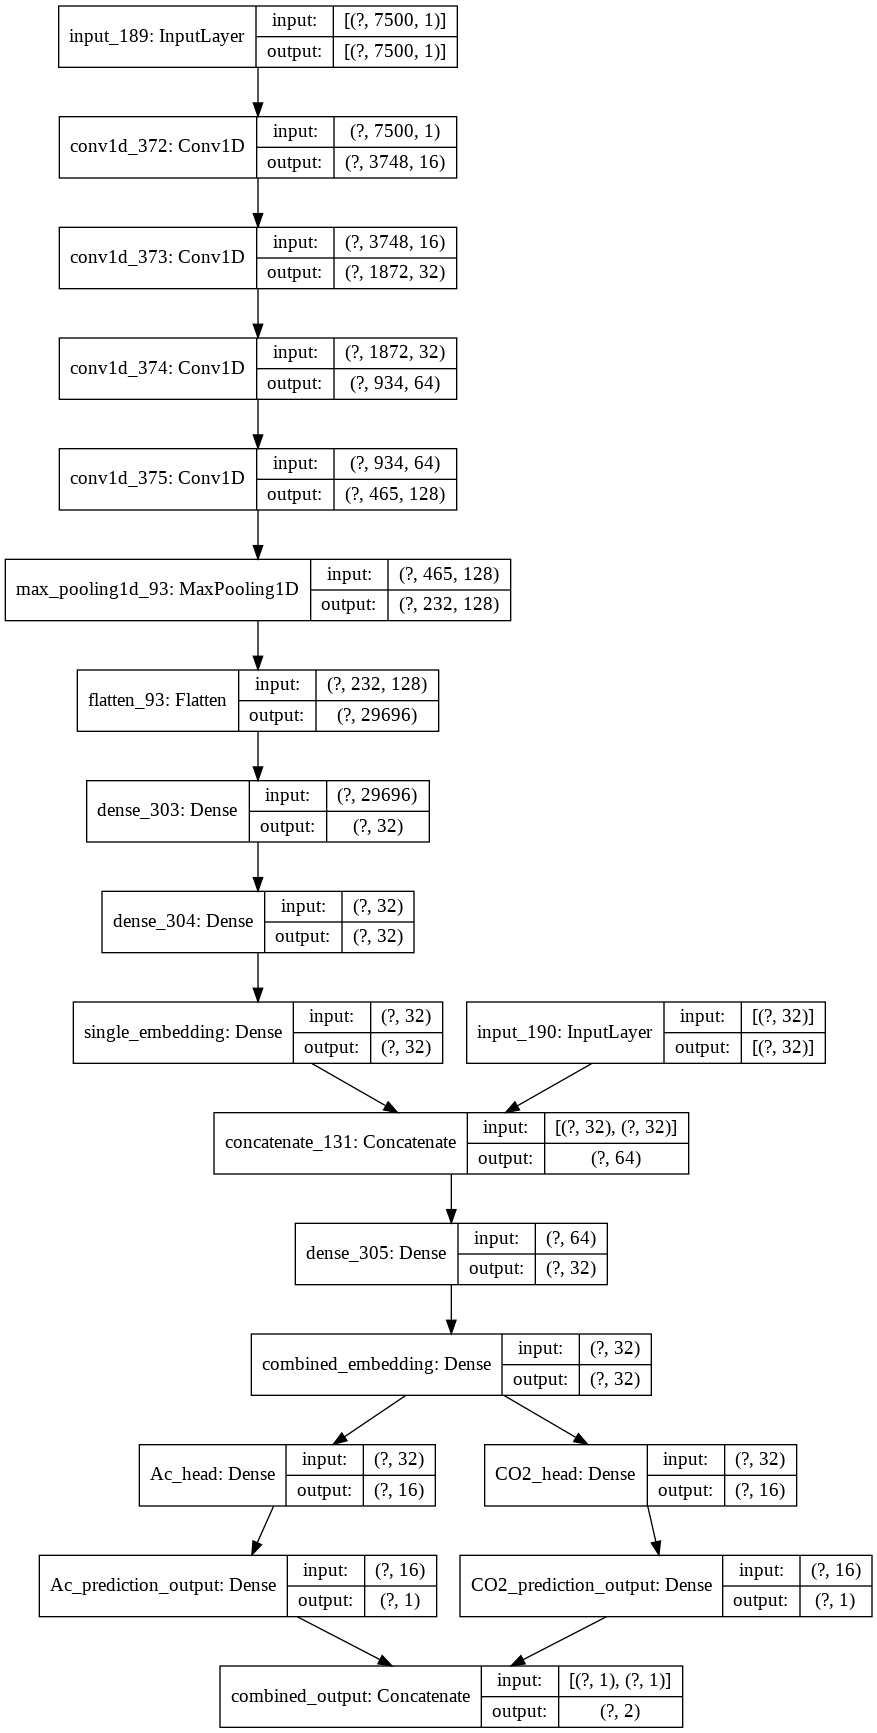

In [119]:
base_network.summary()
model_name = 'base_network_for concatenate quadruplet loss_single_embedding_single_prediction together'
plot_model(base_network, show_shapes=True, to_file= model_name + '.png')

#model_name2 = 'fullmodel concatenate quadruplet loss_single_embedding_single_prediction'
#plot_model(model, show_shapes=True, to_file='ML_models/Model_Maps/' + model_name2 + '.png')

In [ ]:
#plot_model may not work if you don't have graphviz or pydot
#model_name = 'base_network_for concatenate quadruplet loss_single_embedding_single_prediction together'
#plot_model(base_network, show_shapes=True, to_file=model_name + '.png')

#model_name_full = 'fullmodel concatenate quadruplet loss_single_embedding_single_prediction'
#plot_model(model, show_shapes=True, to_file= model_name_full + '.png')

In [113]:
losses = {
	"combined_preds": mse_loss,
	"combined_embedding": mod_quad_loss
}
 
lossWeights = {"combined_preds": 18.0, "combined_embedding": 1.0}





#compiling model
opt = Adam(lr=0.001)  # choose optimiser. RMS is good too!

model.compile(optimizer=opt, loss = losses, loss_weights = lossWeights)



#### This creates the training/validation data for the model (to work with the loss function defined below (**quad_loss**). The first two values are the real acetone and real CO2 values and the last value is a dummy embedding of all 0s that is the same length as the real embedding we want the model to make. I combine the embedding and aceteone/co2 predictions into a single output to make it as easy as possible to use our custom loss function.

In [114]:
pred_train_dict = defaultdict(list)
pred_val_dict = defaultdict(list)
pred_test_dict = defaultdict(list)



dummy_train_dict = defaultdict(list)
dummy_val_dict = defaultdict(list)
dummy_test_dict = defaultdict(list)

for i in range(0, len(cdict)):
    pred_train_list = []
    pred_val_list = []
    pred_test_list = []


    dummy_train_list = []
    dummy_test_list = []
    dummy_val_list = []
    subi = i + 1
    for j in range (0, len(Y_a_test_dict['Y_c' + str(subi)+ '_a_test'])):
        dummyembed = np.zeros((embedding_size))

        twopreds = np.append((Y_a_test_dict['Y_c' + str(subi)+ '_a_test'][j]) , (Y_cn_test_dict['Y_c' + str(subi)+ '_c_test']
        pred_test_list.append(np.array(Y_a_test_dict['Y_c' + str(subi)+ '_a_test'][j], Y_cn_test_dict['Y_c' + str(subi)+ '_c_test'][j]) )
        dummy_test_list.append(dummyembed)
    for k in range (0, len(Y_a_train_dict['Y_c' + str(subi)+ '_a_train'])):
        dummyembed = np.zeros((embedding_size))
        pred_train_list.append(np.array([Y_a_train_dict['Y_c' + str(subi)+ '_a_train'][k],Y_cn_train_dict['Y_c' + str(subi)+ '_c_train'][k]] ))
        dummy_train_list.append(dummyembed)
    for l in range (0, len(Y_a_val_dict['Y_c' + str(subi)+ '_a_val'])):
        dummyembed = np.zeros((embedding_size))
        pred_val_list.append(np.array([Y_a_val_dict['Y_c' + str(subi)+ '_a_val'][l],Y_cn_val_dict['Y_c' + str(subi)+ '_c_val'][l]]))
        dummy_val_list.append(dummyembed)
    dummy_train_dict[i] = np.array(dummy_train_list)
    dummy_test_dict[i] = np.array(dummy_test_list)
    dummy_val_dict[i] = np.array(dummy_val_list)

    pred_train_dict[i] = np.array(pred_train_list)
    pred_val_dict[i] = np.array(pred_val_list) 
    pred_test_dict[i] = np.array(pred_test_list)


     
        

dummy_train_e = concatenate([*unpack_dict(dummy_train_dict)])
dummy_val_e = concatenate([*unpack_dict(dummy_val_dict)])

dummy_train_p = concatenate([*unpack_dict(pred_train_dict)])
dummy_val_p = concatenate([*unpack_dict(pred_val_dict)])
      



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

In [34]:
print(dummy_train_dict[1].shape)
print(pred_train_dict[1].shape)
print(pred_train_dict[1][:,1:2])
print(pred_train_dict[1][:,:1])

(11250, 32)
(11250, 2)
[[24.25]
 [30.  ]
 [26.5 ]
 ...
 [30.  ]
 [22.7 ]
 [21.55]]
[[ 1.5625 ]
 [13.875  ]
 [17.75   ]
 ...
 [ 2.25   ]
 [16.9    ]
 [ 2.15625]]


In [ ]:
#tf.keras.backend.set_floatx('float64')

In [ ]:
#Get current time and date to avoid accidentally overwriting a model
timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)

20200828-172405


In [ ]:
foo = [*unpack_dict(Ac_pred_train_dict)]
print(len(foo))

9


### Here is where we run the model

#### Can comment out /uncomment out checkpoints callback

Epoch 1/50
75/75 [==============================] - 9s 120ms/step - loss: 31513.0547 - concatenate_133_loss: 0.0075 - concatenate_132_loss: 1750.7239 - val_loss: 8519.6562 - val_concatenate_133_loss: 0.0000e+00 - val_concatenate_132_loss: 473.3142
Epoch 2/50
75/75 [==============================] - 8s 104ms/step - loss: 4523.3223 - concatenate_133_loss: 0.0000e+00 - concatenate_132_loss: 251.2956 - val_loss: 3268.9492 - val_concatenate_133_loss: 0.0000e+00 - val_concatenate_132_loss: 181.6083
Epoch 3/50
75/75 [==============================] - 8s 103ms/step - loss: 3091.4058 - concatenate_133_loss: 0.0000e+00 - concatenate_132_loss: 171.7448 - val_loss: 2832.8892 - val_concatenate_133_loss: 0.0000e+00 - val_concatenate_132_loss: 157.3827
Epoch 4/50
75/75 [==============================] - 8s 104ms/step - loss: 2734.4482 - concatenate_133_loss: 0.0000e+00 - concatenate_132_loss: 151.9138 - val_loss: 2218.3630 - val_concatenate_133_loss: 0.0000e+00 - val_concatenate_132_loss: 123.2424
Ep

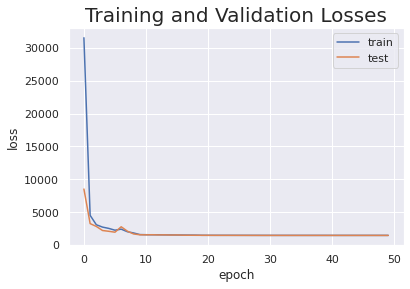

In [115]:
#Running model





#filepath=checkpoint_path + 'checkpoint_model_50epochs' + timestr+ '.hd5'
#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.1
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
hist = model.fit(
    x=[[*unpack_dict(X_train_dict)],[*unpack_dict(X_sensor_train_dict)]],
    y={"combined_preds" : dummy_train_p,"combined_embedding" : dummy_train_e},
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([[*unpack_dict(X_val_dict)],[*unpack_dict(X_sensor_val_dict)]], {"combined_preds" :dummy_val_p, "combined_embedding": dummy_val_e}), verbose =1, 
    callbacks=callbacks_list
    )

    
    #callbacks=callbacks_list
    
#model.save_weights('model.hdf5')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()










In [ ]:
print(X_train_dict['X_c1_train'].shape)

(11250, 7500, 1)


In [86]:
for layername in test_model.layers:
    print(layername.name)

input_109
conv1d_212
batch_normalization_155
activation_144
conv1d_213
batch_normalization_156
activation_145
conv1d_214
batch_normalization_157
activation_146
conv1d_215
batch_normalization_158
activation_147
max_pooling1d_53
flatten_53
dense_183
batch_normalization_159
activation_148
dense_184
batch_normalization_160
activation_149
single_embedding
batch_normalization_161
input_110
activation_150
batch_normalization_154
concatenate_83
dense_185
batch_normalization_162
activation_151
combined_embedding
Ac_head
CO2_head
batch_normalization_163
batch_normalization_164
activation_152
activation_153
Ac_prediction_output
CO2_prediction_output
combined_output


In [ ]:
export_dir = checkpoint_path + '/practice_save_this_way'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Checkpoints/practice_save_this_way/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Checkpoints/practice_save_this_way/assets


## 4) Test the Model 

#### Test the network by making an untrained copy (creating empty network, "testing_embeddings" and getting results "pretrain_pred"). This is to get the predictions for an untrained version of the model.

#### THEN grab the weights from the model trained using our quad loss to generate "trained embedding results " ("posttrain_pred")

#### **This uses data from the fake test set (not seen by the model during training)**

In [ ]:
#Option to load previously-generated model weights
#model = load_model('08072020full50epochs_batch_size30_alpha5.hdf5', custom_objects={'quad_loss': quad_loss})
#model = load_model(checkpoint_path + '/checkpoint_model_1000epochs' + timestr+ '.hd5', custom_objects={'quad_loss': quad_loss})

Setting trainable on an model containing other layers will recursively set the trainable value of all inner layers.
If the value of the trainable attribute is changed after calling compile() on a model, the new value doesn't take effect for this model until compile() is called again.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

In [116]:
# Test the network by making an untrained copy and then a trained copy of the embedding models


test_model_dict = defaultdict(list)
pretrain_ac_dict = defaultdict(list)
pretrain_co2_dict = defaultdict(list)
pretrain_embedding_dict = defaultdict(list)
posttrain_ac_dict = defaultdict(list)
posttrain_co2_dict = defaultdict(list)
posttrain_embedding_dict = defaultdict(list)


for i in range (0, len(cdict)):
    
    subi = i + 1
    test_model = create_base_network(input_trace_shape, input_sensor_shape,
                                         embedding_size=embedding_size)
    pretrain_pred, pretrain_embed = test_model.predict([X_test_dict['X_c' + str(subi)+ '_test'], X_sensor_test_dict['X_c' + str(subi)+ '_s_test']])
    pretrain_ac_dict[i] = pretrain_pred[:,:1]
    pretrain_co2_dict[i] = pretrain_pred[:,1:2]
    pretrain_embedding_dict[i] = pretrain_embed
    
    for layer_target, layer_source in zip(test_model.layers, model.layers[len(cdict)*2].layers):
        weights = layer_source.get_weights()
        layer_target.set_weights(weights)
        del weights


    for layer in test_model.layers:
      if str(layer).find("normalization") != -1:
        layer.trainable = False
        print('Layer ' + layer.name + ' frozen')
      else:
        pass
        
    posttrain_pred, posttrain_embed = test_model.predict([X_test_dict['X_c' + str(subi)+ '_test'],X_sensor_test_dict['X_c' + str(subi)+ '_s_test']])
    posttrain_ac_dict[i] = posttrain_pred[:,:1]
    posttrain_co2_dict[i] = posttrain_pred[:,1:2]
    posttrain_embedding_dict[i] = posttrain_embed

#### This plots the acetone and co2 predictions 

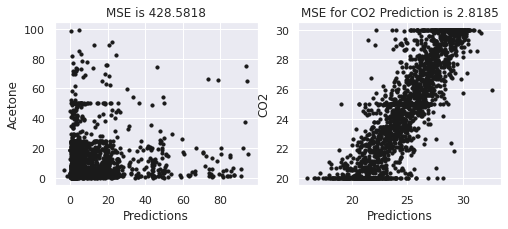

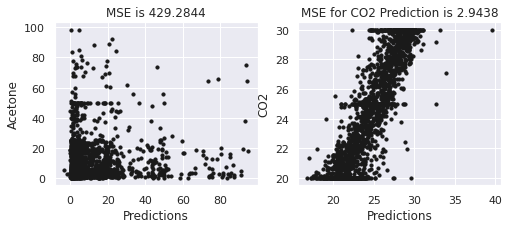

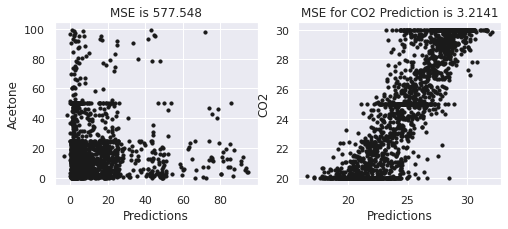

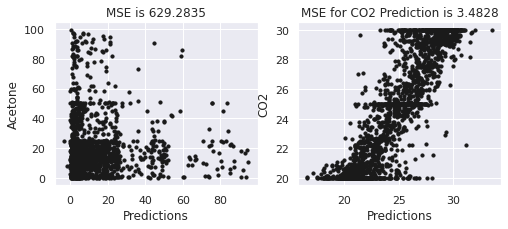

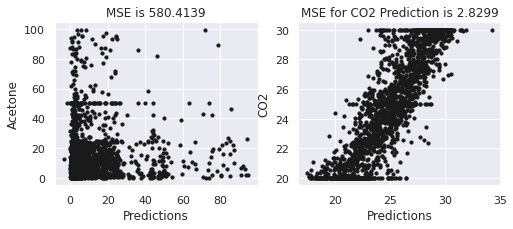

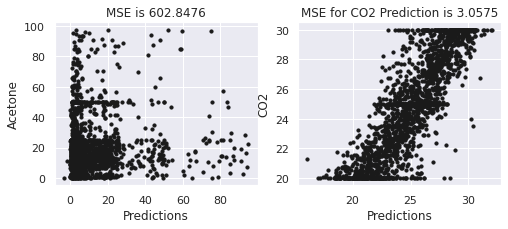

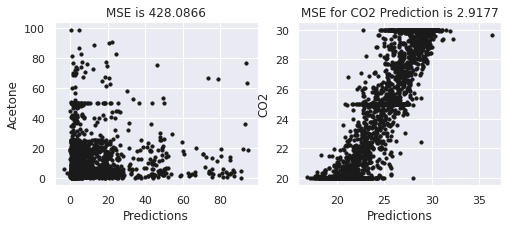

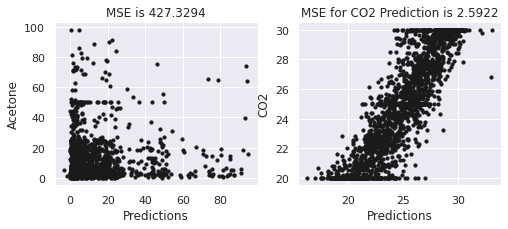

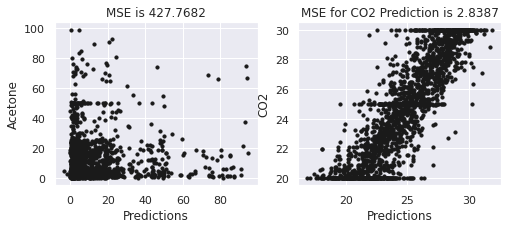

In [118]:
for i in range (0, len(cdict)):
    plt.figure( figsize=(8, 3))
    subi = i + 1
    plt.subplot(121)
    axes = plt.gca()
    #axes.set_xlim([0,100])
    #axes.set_ylim([0,100])
    plt.ylabel('Acetone')
    plt.xlabel('Predictions')
    plt.title('MSE is ' + str(round(mean_squared_error(pred_test_dict[i][:,0], posttrain_ac_dict[i]),4)))
    plt.scatter(posttrain_ac_dict[i], pred_test_dict[i][:,:1], c = 'k' , s = 10)
  
    plt.subplot(122)
    axes = plt.gca()
    #axes.set_xlim([0,3500])
    #axes.set_ylim([0,3500])

    plt.ylabel('CO2')
    plt.xlabel('Predictions')
    plt.title('MSE for CO2 Prediction is ' + str(round(mean_squared_error(pred_test_dict[i][:, 1:2], posttrain_co2_dict[i]),4)))
    plt.scatter(posttrain_co2_dict[i],pred_test_dict[i][:, 1:2], c = 'k' , s = 10)
    plt.show


In [70]:
print(posttrain_ac_dict[1].shape)
print(pred_test_dict[1].shape)
print(pred_test_dict[1][1])
print(pred_test_dict[1][:,0])
print(pred_test_dict[1][:,:1])

(1875, 1)
(1875, 2)
[ 5.34375 28.55   ]
[11.375    5.34375  0.5     ... 10.53125  6.25     1.46875]
[[11.375  ]
 [ 5.34375]
 [ 0.5    ]
 ...
 [10.53125]
 [ 6.25   ]
 [ 1.46875]]


In [ ]:
#option to save the weights
model_name = 'model_trained_all_sensors_with_sensor_embedding_from_E1_combo_emebd_18_to_1'
test_model.save(checkpoint_path + '/weights/' + model_name + '.hdf5')

In [ ]:
## option to read back in the saved model

model_name = 'model_trained_all_sensors_with_sensor_embedding_from_E1_combo_emebd_18_to_1'
model = load_model(checkpoint_path + '/weights/' + model_name + '.hdf5', custom_objects={'quad_loss': quad_loss})

In [ ]:
model.summary()

Model: "functional_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 7500, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_76 (Conv1D)              (None, 3748, 16)     112         input_39[0][0]                   
__________________________________________________________________________________________________
conv1d_77 (Conv1D)              (None, 1872, 32)     3104        conv1d_76[0][0]                  
__________________________________________________________________________________________________
conv1d_78 (Conv1D)              (None, 934, 64)      12352       conv1d_77[0][0]                  
______________________________________________________________________________________

#### Visualize the embeddings
#### TSNE is used to reduce the dimensionality of the embeddings from **embeddiing_size** to 2

In [ ]:
#Creates  embeddings for visualization
tsne_pretrain_embeds_dict = defaultdict(list)
tsne_posttrain_embeds_dict = defaultdict(list)
tsne = TSNE()

for i in range (0, len(cdict)):
    subi = i + 1
    tsne_pretrain_embeds_dict[i] = tsne.fit_transform(pretrain_embedding_dict[i])
    tsne_posttrain_embeds_dict[i] = tsne.fit_transform(posttrain_embedding_dict[i])

#### **ac_return_color, co2_return_color,** and **temp_return_color** are the color dictionaries for the scatter plots. **co2_return_color** is for CO2 values scaled by 2000 (i.e. if you ran the notebook using scale_factor = 1). I use **co2_return_color2** to define the color dictionary for other scale factors (feel free to change that one)

In [ ]:
def sensor_return_color(x):
    if x >=50 and x<90:
        y = 'r'

    elif x >=90 and x<106:
        y ='orange'
    elif x >=106 and x<150:
        y ='gold'
    elif x >=150 and x<180:
        y = 'yellow'
    elif x >=180 and x<200:
        y ='lawngreen'
    elif x >=200 and x<240.5:
        y ='lime'
    elif x >=240.5 and x<270:
        y ='forestgreen'

  
    else:
        y='indigo'
    return(y)

In [ ]:
def ac_return_color(x):
    if x >=0 and x<2.5:
        y = 'r'
    elif x >=2.5 and x<5:
        y = 'salmon'
    elif x >=5 and x<8:
        y ='lightsalmon'
    elif x >=8 and x<10:
        y ='orange'
    elif x >=10 and x<12.5:
        y ='gold'

    elif x >=12.5 and x<15:
        y = 'yellow'
    elif x >=15 and x<20:
        y ='lawngreen'
    elif x >=20 and x<25:
        y ='lime'
    elif x >=25 and x<30:
        y ='forestgreen'


    elif x >=30 and x<40:
        y = 'cyan'
    elif x >=40 and x<50:
        y ='deepskyblue'
    elif x >=50 and x<60:
        y ='blue'
  
    else:
        y='indigo'
    return(y)

In [ ]:
def co2_return_color(x):
    if x >=0 and x<20:
        y = 'r'

    elif x >=20 and x<22:
        y ='orangered'
    elif x >=22 and x<24:
        y ='gold'
    elif x >=24 and x<26:
        y = 'gold'
    elif x >=26 and x<28:
        y ='limegreen'

    elif x >=28 and x<30:
        y ='deepskyblue'
  
    else:
        y='indigo'
    return(y)

In [ ]:
def co2_return_color2(x):
    if x >=0 and x<40:
        y = 'r'

    elif x >=40 and x<42.5:
        y ='orange'
    elif x >=42.5 and x<45:
        y ='gold'
    elif x >=45 and x<47.5:
        y = 'yellow'
    elif x >=47.5 and x<50:
        y ='lawngreen'
    elif x >=50 and x<52.5:
        y ='lime'
    elif x >=52.5 and x<55:
        y ='forestgreen'

    elif x >=55 and x<57.5:
        y = 'cyan'
    elif x >=57.5 and x<60:
        y ='deepskyblue'
  
    else:
        y='indigo'
    return(y)

In [ ]:
def temp_return_color(x):
    if x >=0 and x<12.5:
        y = 'blue'

    elif x >=12.5 and x<15.5:
        y ='royalblue'
    elif x >=15.5 and x<17.5:
        y ='cornflowerblue'
    elif x >=17.5 and x<20:
        y = 'lightskyblue'
    elif x >=20 and x<22.5:
        y ='paleturquoise'
    elif x >=22.5 and x<25.5:
        y ='beige'
    elif x >=25.5 and x<27.5:
        y ='bisque'

    elif x >=27.5 and x<29.5:
        y = 'lightsalmon'
    elif x >=29.5 and x<31.5:
        y ='orangered'
    elif x >=29.5 and x<31.5:
        y ='red'
  
    else:
        y='firebrick'
    return(y)

#### This generates the plots of the embeddings with colors based on acetone, CO2, and temperature
#### The top graph is the embedding from the untrained model (i.e. pre-training), the bottom graph is from the quad-loss-trained model (i.e. post-training)

In [ ]:
translation_dict = defaultdict(list)
for i in range (1, len(cdict)):
  value_list = []
  for sensor in X_sensor_test_dict['X_c' + str(i) + '_s_test']:

    y = np.sum(sensor)
    value_list.append(y)
   
  
    translation_dict['X_c' + str(i) + '_sensor_test'] = np.array(value_list)

In [ ]:
def sensor_scatter(x_list, y_list, subtitle = None):
    
    # We create a scatter plot.
    f = plt.figure(figsize=(7, 7))
    ax = plt.subplot(aspect='equal')
    for i in range(0, len(y_list[0])):
        for j in range(0, len(y_list)):
            ax.scatter(x_list[j][i][0], x_list[j][i][1], lw=0,alpha = 0.5, s=40,
                c=sensor_return_color(y_list[j][i]), 
                       label = y_list[j][i])
    ax.axis('tight')

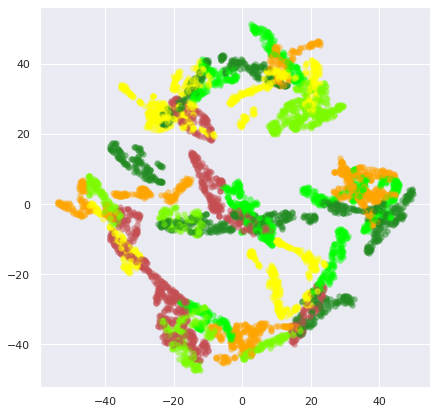

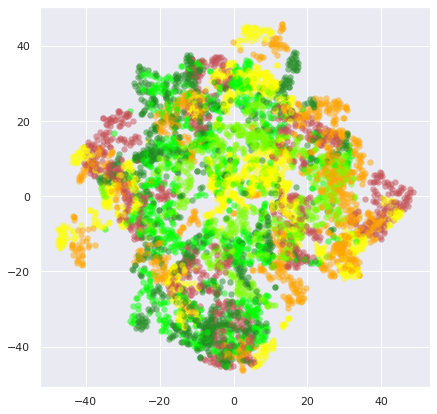

In [ ]:
sensor_scatter([*unpack_dict(tsne_pretrain_embeds_dict)], [*unpack_dict(translation_dict)])
sensor_scatter([*unpack_dict(tsne_posttrain_embeds_dict)], [*unpack_dict(translation_dict)])

In [ ]:
def Ac_scatter(x_list, y_list, subtitle = None):
    
    # We create a scatter plot.
    f = plt.figure(figsize=(7, 7))
    ax = plt.subplot(aspect='equal')
    for i in range(0, len(y_list[0])):
        for j in range(0, len(y_list)):
            ax.scatter(x_list[j][i][0], x_list[j][i][1], lw=0,alpha = 0.5, s=40,
                c=ac_return_color(y_list[j][i]), 
                       label = y_list[j][i])
    ax.axis('tight')

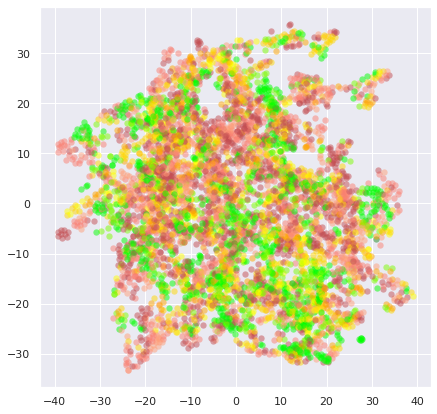

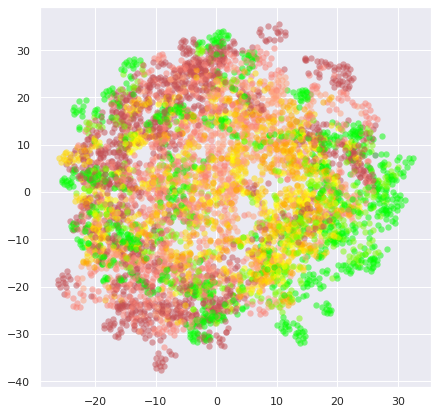

In [ ]:
Ac_scatter([*unpack_dict(tsne_pretrain_embeds_dict)], [*unpack_dict(Y_a_test_dict)])
Ac_scatter([*unpack_dict(tsne_posttrain_embeds_dict)], [*unpack_dict(Y_a_test_dict)])

In [ ]:
def co2_scatter(x_list, y_list, subtitle = None):
    
    # We create a scatter plot.
    f = plt.figure(figsize=(7, 7))
    ax = plt.subplot(aspect='equal')
    for i in range(0, len(y_list[0])):
        for j in range(0, len(y_list)):
            ax.scatter(x_list[j][i][0], x_list[j][i][1], lw=0,alpha = 0.5, s=40,
                c=co2_return_color(y_list[j][i]), 
                       label = y_list[j][i])
    ax.axis('tight')

In [ ]:
co2_scatter([*unpack_dict(tsne_pretrain_embeds_dict)], [*unpack_dict(Y_c_test_dict)])
co2_scatter([*unpack_dict(tsne_posttrain_embeds_dict)], [*unpack_dict(Y_c_test_dict)])

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f794f10c2f0> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f794dffb840> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
def temp_scatter(x_list, y_list, subtitle = None):
    
    # We create a scatter plot.
    f = plt.figure(figsize=(7, 7))
    ax = plt.subplot(aspect='equal')
    for i in range(0, len(y_list[0])):
        for j in range(0, len(y_list)):
            ax.scatter(x_list[j][i][0], x_list[j][i][1], lw=0,alpha = 0.5, s=40,
                c=temp_return_color(y_list[j][i]), 
                       label = y_list[j][i])
    ax.axis('tight')

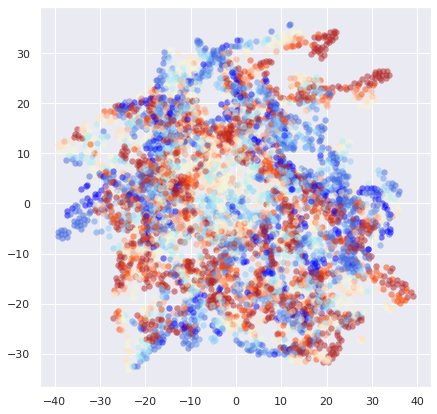

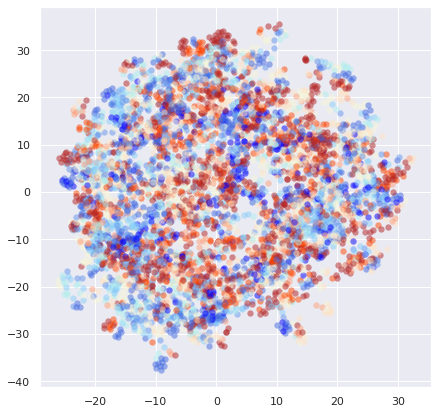

In [ ]:
temp_scatter([*unpack_dict(tsne_pretrain_embeds_dict)], [*unpack_dict(Y_t_test_dict)])
temp_scatter([*unpack_dict(tsne_posttrain_embeds_dict)], [*unpack_dict(Y_t_test_dict)])

## **Transfer Learning**

In [ ]:
## option to read back in the saved model

model_name = 'model_trained_no_16'
model = load_model(checkpoint_path + '/weights/' + model_name + '.hdf5', custom_objects={'quad_loss': quad_loss})

base_tuning_model_t = create_base_network(input_trace_shape, input_sensor_shape,
                                     embedding_size=embedding_size)

for layer_target, layer_source in zip(base_tuning_model_t.layers, model.layers[len(cdict)*2].layers):
    weights = layer_source.get_weights()
    layer_target.set_weights(weights)
    del weights
  
base_tuning_model_t.summary()
#base_tuning_model._layers.pop(-1)
#base_tuning_model._layers.pop(-2)
#base_tuning_model._layers.pop(-3)
#base_tuning_model._layers.pop(-4)
#base_tuning_model._layers.pop(-6)




Model: "functional_79"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           [(None, 7500, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_120 (Conv1D)             (None, 3748, 16)     112         input_63[0][0]                   
__________________________________________________________________________________________________
conv1d_121 (Conv1D)             (None, 1872, 32)     3104        conv1d_120[0][0]                 
__________________________________________________________________________________________________
conv1d_122 (Conv1D)             (None, 934, 64)      12352       conv1d_121[0][0]                 
______________________________________________________________________________________

In [ ]:
for layer in base_tuning_model.layers:
    if not str(layer).find("convolutional") != -1:
      layer.trainable = False
      print('Layer ' + layer.name + ' frozen')

      

Layer max_pooling1d_19 frozen
Layer flatten_31 frozen
Layer dense_105 frozen
Layer dense_106 frozen
Layer single_embedding frozen
Layer input_40 frozen
Layer concatenate_74 frozen
Layer dense_107 frozen
Layer combined_embedding frozen
Layer Ac_head frozen
Layer CO2_head frozen
Layer Ac_prediction frozen
Layer CO2_prediction frozen
Layer concatenate_75 frozen


In [ ]:
#For fine-tuning
##############################################################
#Removes input AND last layer from base_model so that we can add our own
base_tuning_model._layers.pop(0)
base_tuning_model._layers.pop(-1)
base_tuning_model.summary()

#Explicitly turn off training so that base model doesn't change
for layer in base_tuning_model.layers[:]:
 
    layer.trainable = False 
    print('Layer ' + layer.name + ' frozen')
    #print(layer, layer.trainable)

Model: "functional_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_76 (Conv1D)              (None, 3748, 16)     112         input_39[0][0]                   
__________________________________________________________________________________________________
conv1d_77 (Conv1D)              (None, 1872, 32)     3104        conv1d_76[0][0]                  
__________________________________________________________________________________________________
conv1d_78 (Conv1D)              (None, 934, 64)      12352       conv1d_77[0][0]                  
__________________________________________________________________________________________________
conv1d_79 (Conv1D)              (None, 465, 128)     49280       conv1d_78[0][0]                  
______________________________________________________________________________________

In [ ]:
transfer_layer = base_tuning_model.output
in1 = Input(shape=input_trace_shape)
in2 = Input(shape=input_sensor_shape)
z = Flatten()(transfer_layer)
z = Dense(32, activation = 'relu')(z)
z = Dense(32, activation = 'relu')(z)
Ac_head = Dense(16, activation = 'relu')(z)
Ac_pred = Dense(16, activation = 'relu', name = "Acetone_pred2")(Ac_head)

CO2_head = Dense(16, activation = 'relu')(z)
CO2_pred = Dense(16, activation = 'relu', name = "CO2_pred2")(CO2_head)
mergedpred = concatenate([Ac_pred, CO2_pred], axis = -1)
transfer_model = Model(inputs = [in1, in2], outputs = mergedpred)

transfer_model.summary()


ValueError: ignored

In [ ]:
print(base_tuning_model.input)

[<tf.Tensor 'input_37:0' shape=(None, 7500, 1) dtype=float32>, <tf.Tensor 'input_38:0' shape=(None, 32) dtype=float32>]


In [ ]:

dummy_train_dict = defaultdict(list)
dummy_val_dict = defaultdict(list)
dummy_test_dict = defaultdict(list)

for i in range(0, len(cdict)):
    dummy_train_list = []
    dummy_test_list = []
    dummy_val_list = []
    subi = i + 1
    for j in range (0, len(Y_a_test_dict['Y_c' + str(subi)+ '_a_test'])):
        dummyembed = np.zeros((embedding_size))
        twopreds = np.append((Y_a_test_dict['Y_c' + str(subi)+ '_a_test'][j]) , (Y_cn_test_dict['Y_c' + str(subi)+ '_c_test'][j]))
        comboembed = np.append(twopreds,dummyembed)
        dummy_test_list.append(comboembed)
    for k in range (0, len(Y_a_train_dict['Y_c' + str(subi)+ '_a_train'])):
        dummyembed = np.zeros((embedding_size))
        twopreds = np.append((Y_a_train_dict['Y_c' + str(subi)+ '_a_train'][k]) , (Y_cn_train_dict['Y_c' + str(subi)+ '_c_train'][k]))
        comboembed = np.append(twopreds,dummyembed)
        dummy_train_list.append(comboembed)
    for l in range (0, len(Y_a_val_dict['Y_c' + str(subi)+ '_a_val'])):
        dummyembed = np.zeros((embedding_size))
        twopreds = np.append((Y_a_val_dict['Y_c' + str(subi)+ '_a_val'][l]), (Y_cn_val_dict['Y_c' + str(subi)+ '_c_val'][l]))
        comboembed = np.append(twopreds,dummyembed)
        dummy_val_list.append(comboembed)
    dummy_train_dict[i] = np.array(dummy_train_list)
    dummy_test_dict[i] = np.array(dummy_test_list)
    dummy_val_dict[i] = np.array(dummy_val_list)
     
        

dummy_train = concatenate([*unpack_dict(dummy_train_dict)])
dummy_val = concatenate([*unpack_dict(dummy_val_dict)])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [ ]:
#compiling model
opt = Adam(lr=0.001)  # choose optimiser. RMS is good too!

base_tuning_model_t.compile(loss=quad_loss,
              optimizer=opt)

In [ ]:
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.1
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
hist = base_tuning_model_t.fit(
    x=[[*unpack_dict(X_train_dict)],[*unpack_dict(X_sensor_train_dict)]],
    y=dummy_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([[*unpack_dict(X_val_dict)],[*unpack_dict(X_sensor_val_dict)]], dummy_val), verbose =1, 
    callbacks=callbacks_list
    )

    
    #callbacks=callbacks_list
    
#model.save_weights('model.hdf5')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Epoch 1/50


ValueError: ignored

In [ ]:
preds = base_tuning_model_t.predict([[*unpack_dict(X_val_dict)],[*unpack_dict(X_sensor_val_dict)]], dummy_val)

In [ ]:
print(X_val_dict.keys())

dict_keys(['X_c1_val', 'X_c2_val', 'X_c3_val', 'X_c4_val', 'X_c5_val', 'X_c6_val', 'X_c7_val', 'X_c8_val', 'X_c9_val'])


In [ ]:
def get_fine_tuner_ac(input_trace_shape, input_sensor_shape, embedding_size):
 
    input_trace = Input(shape=input_trace_shape)
    input_sensor = Input(shape=input_sensor_shape)
    Z = base_tuning_model([input_trace, input_sensor], training = False)
    Z = Dense(4)(Z)
    Z = Activation('tanh')(Z)
    Z = BatchNormalization()(Z)
    Z = Dropout(0.2)(Z)
    Z = Dense(8, kernel_constraint=max_norm(3))(Z)
    #Z = Dense(8)(Z)
    Z = Activation('tanh')(Z)
    Z = BatchNormalization()(Z)
    output = Dense(output_size)(Z)
    new_model = Model(In,output)
    new_model.compile(loss="mse", optimizer='rmsprop', metrics=['mae', 'mse', 'accuracy'])
    return(new_model)


new_model = get_fine_tuner_ac((X_Y_dict['X_train'].shape[1],))

In [ ]:
def create_base_network(input_trace_shape, input_sensor_shape, embedding_size):
#def create_base_network(input_trace_shape, input_metadata_shape, embedding_size):
    """
    Base network to be shared (eq. to feature extraction).
    """
    input_trace = Input(shape=input_trace_shape)
    input_sensor = Input(shape=input_sensor_shape)
    #trunc_meta = Lambda(lambda x: x[: , 1:-1:2])(input_meta)

    x = Convolution1D(filters = 16, kernel_size = 6, strides = 2, activation='relu')(input_trace)
    x = Convolution1D(filters = 32, kernel_size = 6, strides = 2, activation='relu')(x)
    x = Convolution1D(filters = 64, kernel_size = 6, strides = 2, activation='relu')(x)
    x = Convolution1D(filters = 128, kernel_size = 6, strides = 2, activation='relu')(x)
    #x = Convolution1D(filters = 256, kernel_size = 6, strides = 2, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    embedding = Dense(embedding_size, activation = 'relu', name = 'single_embedding')(x)
    
    
    embedding_plus_sensor = concatenate([embedding, input_sensor], axis = -1)
    embedding_plus_sensor = Dense(32, activation = 'relu')(embedding_plus_sensor)
    embedding_plus_sensor = Dense(embedding_size, activation = 'relu', name= 'combined_embedding')(embedding_plus_sensor)
    #Acetone head

    Ac_head = Dense(16, activation = 'relu', name = 'Ac_head')(embedding_plus_sensor)
    predAc = Dense(1, activation= 'linear', name = 'Ac_prediction')(Ac_head)
    
    #CO2 head
    CO2_head = Dense(16, activation='relu', name = 'CO2_head')(embedding_plus_sensor)
    predCO2 = Dense(1, activation= 'linear', name = 'CO2_prediction')(CO2_head)
    
     #Merge the embeddings and predictions as a single ouptut of the form (Acetone_prediction, CO2_prediction, embedding)
    mergedpred = concatenate([predAc, predCO2], axis = -1)

    merged = concatenate([mergedpred, embedding_plus_sensor], axis = -1)
    
    base_network = Model(inputs=[input_trace, input_sensor], outputs=merged)

    return base_network

### Testing model on real data

## IF YOU WANT TO READ FROM A PICKLE, SKIP TO STEP **"START HERE TO READ FROM PICKLE"**

In [ ]:
real_test_db_df=pd.read_csv('/content/drive/My Drive/Test_Log for Tests 3000- 10000.csv')
for column in real_test_db_df[['Acetone', 'CO2', 'H2O', 'Sensor', 'Test_that_day', 'Time_Btwn_s', 'Instr_Temp', 'Baseline', 'File']]:
    real_test_db_df[column] = pd.to_numeric(real_test_db_df[column])
real_test_db_df.set_index('File', inplace = True)
real_test_db_df.head()

,Acetone,Amb_Temp,Area_neg,Area_pos,Area_total,Baseline,Baseline_Dip,CO2,Cross_t,Data_pts,Date,FLAG,H2O,Instr,Instr_Temp,New_Baseline,Notes,Other,Peak_neg,Peak_neg_t,Peak_pos,Peak_pos_t,Raw_data,Sample_rate,Sensor,Test_name,Test_that_day,Time,Time_Btwn_s,Total CO2,a_,b_,c_,cpn_mV,cpn_time,dx2_cross_t,dx2_neg_peak,dx2_neg_peak_t,dx2_pos_peak,dx2_pos_peak_t,slope_cross_t,slope_neg_peak_t,slope_neg_peak_t_ix,slope_pos_peak,slope_pos_peak_t
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3066,0.0,NaN,-1808.0,1227.81,-246476.19,30.135274,0.0860,40000,8.335766,15056,2020-02-14,NaN,10,38107,25.0,30.22132,NaN,0,-447.553442,2.145985,43.813239,13.000000,wav3033,250,10,4% CO2 through plain water,34.0,13:47:57,174,4.9,-5.79617,133.05928,-706.403859,-150.636755,5.489051,0.620438,-0.089458,0.284672,0.017774,1.270073,2.204380,0.569343,78.0,0.804884,4.051095
3067,0.0,NaN,-1582.0,1051.28,-215740.72,30.761160,1.5244,40000,8.197080,13151,2020-02-14,NaN,10,38263,25.0,32.28560,NaN,0,-403.366245,2.036496,36.711029,12.583941,wav3033,250,9,4% CO2 through plain water,34.0,13:48:11,167,4.9,-5.41429,120.88287,-627.088998,-147.035370,5.167883,0.605839,-0.087046,0.262774,0.016942,1.051095,2.116788,0.562044,77.0,0.748826,3.678832
3068,0.0,NaN,-1858.0,1263.37,-253392.63,29.958300,-0.3156,40000,8.343066,14292,2020-02-14,NaN,10,38107,25.0,29.64275,NaN,0,-459.888902,2.145985,44.770615,12.970803,wav3034,250,10,4% CO2 through plain water,35.0,13:50:37,160,5.3,-5.96187,136.74495,-725.885639,-153.321252,5.510949,0.620438,-0.091577,0.284672,0.018009,1.240876,2.211679,0.562044,77.0,0.830898,3.956204
3069,0.0,NaN,-1634.0,1060.17,-222880.83,30.913342,0.5003,40000,8.211679,13189,2020-02-14,NaN,10,38263,25.0,31.41365,NaN,0,-415.938610,2.058394,37.565889,12.540146,wav3034,250,9,4% CO2 through plain water,35.0,13:50:45,154,5.3,-5.62095,125.32375,-650.088399,-155.037314,5.131387,0.613139,-0.089616,0.262774,0.017526,1.175182,2.116788,0.576642,79.0,0.774648,3.693431
3070,0.0,NaN,-1916.0,1235.43,-261338.57,31.076837,-0.3629,40000,8.350365,14040,2020-02-14,NaN,10,38107,25.0,30.71398,NaN,0,-473.780007,2.138686,45.577067,12.379562,wav3035,250,10,4% CO2 through plain water,36.0,13:52:54,137,5.7,-6.34328,142.80746,-750.186308,-143.748291,5.678832,0.627737,-0.093931,0.284672,0.018833,1.175182,2.204380,0.591241,81.0,0.853851,3.956204


In [ ]:
real_test_set = get_test_list (real_test_db_df, 'all', '+', 10, 19, 9000, 10000)

In [ ]:
real_test_db_df.head(-1)

,Acetone,Amb_Temp,Area_neg,Area_pos,Area_total,Baseline,Baseline_Dip,CO2,Cross_t,Data_pts,Date,FLAG,H2O,Instr,Instr_Temp,New_Baseline,Notes,Other,Peak_neg,Peak_neg_t,Peak_pos,Peak_pos_t,Raw_data,Sample_rate,Sensor,Test_name,Test_that_day,Time,Time_Btwn_s,Total CO2,a_,b_,c_,cpn_mV,cpn_time,dx2_cross_t,dx2_neg_peak,dx2_neg_peak_t,dx2_pos_peak,dx2_pos_peak_t,slope_cross_t,slope_neg_peak_t,slope_neg_peak_t_ix,slope_pos_peak,slope_pos_peak_t
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3066,0.00,NaN,-1808.0,1227.81,-246476.19,30.135274,0.0860,40000,8.335766,15056,2020-02-14,NaN,10,38107,25.00,30.22132,NaN,0,-447.553442,2.145985,43.813239,13.000000,wav3033,250,10,4% CO2 through plain water,34.0,13:47:57,174,4.9,-5.79617,133.05928,-706.403859,-150.636755,5.489051,0.620438,-0.089458,0.284672,0.017774,1.270073,2.204380,0.569343,78.0,0.804884,4.051095
3067,0.00,NaN,-1582.0,1051.28,-215740.72,30.761160,1.5244,40000,8.197080,13151,2020-02-14,NaN,10,38263,25.00,32.28560,NaN,0,-403.366245,2.036496,36.711029,12.583941,wav3033,250,9,4% CO2 through plain water,34.0,13:48:11,167,4.9,-5.41429,120.88287,-627.088998,-147.035370,5.167883,0.605839,-0.087046,0.262774,0.016942,1.051095,2.116788,0.562044,77.0,0.748826,3.678832
3068,0.00,NaN,-1858.0,1263.37,-253392.63,29.958300,-0.3156,40000,8.343066,14292,2020-02-14,NaN,10,38107,25.00,29.64275,NaN,0,-459.888902,2.145985,44.770615,12.970803,wav3034,250,10,4% CO2 through plain water,35.0,13:50:37,160,5.3,-5.96187,136.74495,-725.885639,-153.321252,5.510949,0.620438,-0.091577,0.284672,0.018009,1.240876,2.211679,0.562044,77.0,0.830898,3.956204
3069,0.00,NaN,-1634.0,1060.17,-222880.83,30.913342,0.5003,40000,8.211679,13189,2020-02-14,NaN,10,38263,25.00,31.41365,NaN,0,-415.938610,2.058394,37.565889,12.540146,wav3034,250,9,4% CO2 through plain water,35.0,13:50:45,154,5.3,-5.62095,125.32375,-650.088399,-155.037314,5.131387,0.613139,-0.089616,0.262774,0.017526,1.175182,2.116788,0.576642,79.0,0.774648,3.693431
3070,0.00,NaN,-1916.0,1235.43,-261338.57,31.076837,-0.3629,40000,8.350365,14040,2020-02-14,NaN,10,38107,25.00,30.71398,NaN,0,-473.780007,2.138686,45.577067,12.379562,wav3035,250,10,4% CO2 through plain water,36.0,13:52:54,137,5.7,-6.34328,142.80746,-750.186308,-143.748291,5.678832,0.627737,-0.093931,0.284672,0.018833,1.175182,2.204380,0.591241,81.0,0.853851,3.956204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9972,18.75,NaN,-1267.0,0.00,-1267041.00,144.735140,NaN,50000,7.178000,118901,2020-08-14,NaN,10,1,34.82,NaN,NaN,0,-336.125238,2.103000,62.853625,11.918000,pdata9972,250,19,Combo of 9912 and 9918 | Weight - 0.5,68.0,NaN,859,33.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9973,18.75,NaN,-852.0,1066.52,-851709.48,151.150174,NaN,50000,6.931000,119500,2020-08-14,NaN,10,2,35.14,NaN,NaN,0,-256.505626,1.776000,28.589478,11.817000,pdata9973,250,18,Combo of 9913 and 9919 | Weight - 0.5,68.0,NaN,858,33.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9974,18.75,NaN,-1289.0,0.00,-1289036.00,141.891104,NaN,50000,6.361000,121364,2020-08-14,NaN,10,4,33.63,NaN,NaN,0,-385.932706,1.689000,70.629197,10.897000,pdata9974,250,16,Combo of 9914 and 9920 | Weight - 0.5,68.0,NaN,862,33.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
scale = 1
cut_off_time = 30
scale_factor = 1

real_test_list = []
real_Ac_list = []
real_co2_list = []
real_temp_list = []
real_metadata_list = []

for j in real_test_set:
        ac = float(real_test_db_df.loc[j, 'Acetone'])
        co2 = int(real_test_db_df.loc[j, 'CO2'])/(2000*scale_factor)
        temp = float(real_test_db_df.loc[j, 'Instr_Temp'])
        bs = float(real_test_db_df.loc[j, 'Baseline'])
        timebtwn = float(real_test_db_df.loc[j, 'Time_Btwn_s'])
        totalco2 = float(real_test_db_df.loc[j, 'Total CO2'])
        testday = float(real_test_db_df.loc[j, 'Test_that_day'])
        sample_rate = int(real_test_db_df.loc[j, 'Sample_rate'])
        num_of_samples = int(cut_off_time*sample_rate/scale)
    
        full_data = pd.read_csv(real_path+ '/test_output' + str(int(j)) + '.csv',header = 0)
        sig_data = full_data[['Second','mV_rolling_mean']].truncate(after = cut_off_time*sample_rate-1)
        mV_data = sig_data['mV_rolling_mean'].to_numpy()
        mV_data[np.isnan(mV_data)]=0
               
        #if sample_rate == 500:
        if sample_rate == 500:
            mV_data = mV_data.reshape(-1, 2).mean(axis=1)
       
        real_test_list.append(mV_data)
        real_Ac_list.append(ac)
        real_co2_list.append(co2)
        real_temp_list.append(temp)
        real_metadata_list.append([temp, bs, timebtwn, totalco2, testday])
X_real = np.squeeze(np.array(real_test_list))[...,np.newaxis]
X_real_n = pad_sequences(X_real, maxlen = 7500)
Ac_real = np.array(real_Ac_list)
CO2_real = np.array(real_co2_list)
temp_real = np.array(real_temp_list)
metadata_real = np.array(real_metadata_list)
real_data_dict = {'X_real': X_real_n, 'Ac_real': Ac_real, 'CO2_real': CO2_real, 'temp_real': temp_real, 'metadata_real': metadata_real}

In [ ]:
# To save real_data_dict as a pickle



with open(pickle_path +'/real_data_dict_metadata_19.pickle', 'wb') as handle:
    pickle.dump(real_data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


## **START HERE TO READ FROM PICKLE**

In [ ]:
sos = '9'
# To load real data pickle
#with open(pickle_path +'/real_data_dict_sensor_train_metadata_19_only_no_fakes.pickle', 'rb') as handle:
with open(pickle_path +'/real_data_' + sos + '_csvs_sensor_metadata.pickle', 'rb') as handle:
    
    real_data_dict = pickle.load(handle)
print(real_data_dict.keys())

dict_keys(['testnum', 'csvs', 'Ac', 'CO2', 'temp', 'sensor', 'metadata'])


In [ ]:
#To run a predicted embedding
with open(pickle_path +'/avg_embeddings_from_real_data_all_sensors.pickle', 'rb') as handle:
    
    predicted_embedding_source = pickle.load(handle)

In [ ]:
print(predicted_embedding_source.keys())

dict_keys(['Real data for 19', 'Real data for 18', 'Real data for 16', 'Real data for 15', 'Real data for 14', 'Real data for 10', 'Real data for 9', 'Predicted Real data for 16', 'Predicted Real data for 16_12Ar2', 'Predicted Real data for 16_12B', '12ATrain Real data for 16_12A', '12BTrain Real data for 16_12B', '18ATrain Real data for 16_18A', '18BTrain Real data for 16_18B', '36ATrain Real data for 16_36A', '30ATrain Real data for 16_30A', 'Train Real data for 16_w_ratio_E1', 'Train Real data for 19_w_ratio_E1', 'Train Real data for 15_w_ratio_E1', 'Train Real data for 14_w_ratio_E1', 'Train Real data for 10_w_ratio_E1', 'Train Real data for 9_w_ratio_E1', 'Train Real data for 9_w_ratio_E1_noratio', 'Train Real data for 10_w_ratio_E1_noratio', 'Train Real data for 14_w_ratio_E1_noratio', 'Train Real data for 15_w_ratio_E1_noratio', 'Train Real data for 16_w_ratio_E1_noratio', 'Train Real data for 19_w_ratio_E1_noratio'])


In [ ]:
print(predicted_embedding_source['Train Real data for ' + sos + '_w_ratio_E1'])

[1.7896648e+01 1.3621886e+01 0.0000000e+00 6.1280079e+00 1.7611060e-02
 2.7757269e+01 1.5687317e+02 0.0000000e+00 9.4863495e+01 0.0000000e+00
 2.3786688e-01 0.0000000e+00 5.7315659e+01 0.0000000e+00 6.2895809e+01
 2.7742705e-01 9.3263084e+01 0.0000000e+00 0.0000000e+00 2.1540517e-02
 1.6916938e-02 1.9615947e+02 0.0000000e+00 3.1467555e+00 0.0000000e+00
 1.1166279e+02 4.7568153e+01 0.0000000e+00 1.1900767e+00 1.7347163e+02
 0.0000000e+00 3.2530391e-01]


THIS IS TO RUN WITH A PREDICTED EMBEDDING (TRAINED ON REAL DATA BUT NOT FROM THAT PARTICULAR SENSOR)

In [ ]:

list16 = []



for i in range(0,len(real_data_dict['csvs'])):



    #list16.append(predicted_embedding_source[test_embedding+'Train Real data for 16_' + test_embedding])
    list16.append(predicted_embedding_source['Train Real data for ' + sos + '_w_ratio_E1'])

real_data_dict['predicted_sensor'] = np.array(list16)

In [ ]:
print(len(real_data_dict['predicted_sensor']))

126


##If you want to run a previoulsy-generated model (i.e. load from weights)

THIS IS TO RUN WITH REAL DATA EMBEDDING (MODEL TRAINED ON DATA)

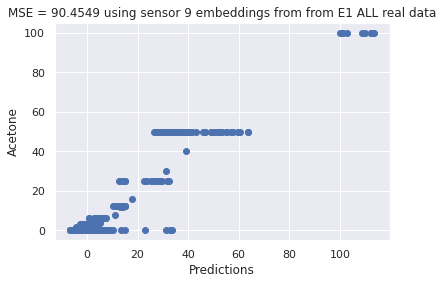

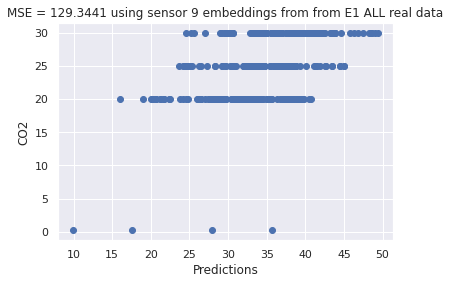

In [ ]:
# THIS IS TO RUN WITH REAL DATA EMBEDDING
real_test_model = create_base_network(input_trace_shape, input_sensor_shape,
                                     embedding_size=embedding_size)

for layer_target, layer_source in zip(real_test_model.layers, model.layers):
    weights = layer_source.get_weights()
    layer_target.set_weights(weights)
    del weights




predictions, embeddings = real_test_model.predict([real_data_dict['csvs'], real_data_dict['predicted_sensor']])
real_data_pred_Ac = predictions[:,:1]
real_data_pred_CO2 = predictions[:,1:2]


ace_mse = mean_squared_error(real_data_dict['Ac'],real_data_pred_Ac)
co2_mse = mean_squared_error(real_data_dict['CO2'], real_data_pred_CO2)


plt.figure()
plt.ylabel('Acetone')
plt.xlabel('Predictions')
plt.title('MSE = ' + str(round(ace_mse,4)) + ' using sensor ' + sos + ' embeddings from from E1 ALL real data')

plt.scatter(real_data_pred_Ac, real_data_dict['Ac'])

plt.show()
#print(preds)
plt.figure()
plt.ylabel('CO2')
plt.xlabel('Predictions')
plt.title('MSE = ' + str(round(co2_mse, 4))+ ' using sensor ' + sos + ' embeddings from from E1 ALL real data')
plt.scatter(real_data_pred_CO2, real_data_dict['CO2'])
plt.show()

In [ ]:
print(predictions)

[[ 2.8656056  20.6755    ]
 [ 0.7421535  21.77509   ]
 [ 0.9465909  28.712389  ]
 [ 1.1008003  29.045195  ]
 [ 2.0107164  19.272009  ]
 [ 1.0490383  20.162304  ]
 [ 0.8991302  26.260382  ]
 [ 1.2581012  28.635937  ]
 [ 5.168285   18.233152  ]
 [ 3.1597383  20.830036  ]
 [ 2.6533606  28.396172  ]
 [ 3.9484134  28.620413  ]
 [ 8.750181   16.829855  ]
 [ 6.6378016  19.906378  ]
 [ 6.562484   27.88901   ]
 [ 6.1724787  28.9124    ]
 [15.220572   19.70438   ]
 [14.275575   21.835737  ]
 [13.195102   28.512035  ]
 [12.964162   28.90705   ]
 [21.189259   19.158226  ]
 [22.780617   21.796597  ]
 [24.257666   24.885532  ]
 [24.63795    27.143684  ]
 [ 2.206293   21.980644  ]
 [ 3.329203   22.351463  ]
 [ 3.7777634  28.887724  ]
 [ 2.7479284  29.49608   ]
 [ 2.3596046  20.468393  ]
 [ 1.2335274  21.477436  ]
 [ 1.5293947  28.037334  ]
 [ 2.613682   29.39788   ]
 [ 4.740562   21.583483  ]
 [ 4.1580195  22.524197  ]
 [ 3.0462081  27.052408  ]
 [ 5.7830315  28.637617  ]
 [10.782999   19.897474  ]
 

In [ ]:
foo = np.array(real_data_pred_Ac[0:embedding_size])
print(foo)

[[ 2.8656056 20.6755   ]
 [ 0.7421535 21.77509  ]
 [ 0.9465909 28.712389 ]
 [ 1.1008003 29.045195 ]
 [ 2.0107164 19.272009 ]
 [ 1.0490383 20.162304 ]
 [ 0.8991302 26.260382 ]
 [ 1.2581012 28.635937 ]
 [ 5.168285  18.233152 ]
 [ 3.1597383 20.830036 ]
 [ 2.6533606 28.396172 ]
 [ 3.9484134 28.620413 ]
 [ 8.750181  16.829855 ]
 [ 6.6378016 19.906378 ]
 [ 6.562484  27.88901  ]
 [ 6.1724787 28.9124   ]
 [15.220572  19.70438  ]
 [14.275575  21.835737 ]
 [13.195102  28.512035 ]
 [12.964162  28.90705  ]
 [21.189259  19.158226 ]
 [22.780617  21.796597 ]
 [24.257666  24.885532 ]
 [24.63795   27.143684 ]
 [ 2.206293  21.980644 ]
 [ 3.329203  22.351463 ]
 [ 3.7777634 28.887724 ]
 [ 2.7479284 29.49608  ]
 [ 2.3596046 20.468393 ]
 [ 1.2335274 21.477436 ]
 [ 1.5293947 28.037334 ]
 [ 2.613682  29.39788  ]]


# 5) Saving the model 

## The MODEL DIR must unfortunately be stored outside of the drive, so you **MUST** remember to drag the folder into "My Drive" before you close the session

In [ ]:
import os
!apt-get update && apt-get -qq install xxd

In [ ]:
# Define paths to model files

base_name = 'model_19_64'

MODELS_DIR = '64/'
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
MODEL_TF = MODELS_DIR + base_name + '.pb'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + base_name + '_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + base_name + '_quant.tflite'
MODEL_TFLITE_DRQ = MODELS_DIR + base_name + '_DRQ_quant.tflite'
MODEL_TFLITE_FI = MODELS_DIR + base_name + '_FI_quant.tflite'
MODEL_TFLITE_F16 = MODELS_DIR + base_name + '_F16.tflite'

MODEL_TFLITE_MICRO = MODELS_DIR + base_name + '_no_quant.cc'
MODEL_TFLITE_MICRO_DRQ =MODELS_DIR + base_name + '_DRQ_quant.cc'
MODEL_TFLITE_MICRO_FI =MODELS_DIR + base_name + '_FI_quant.cc'
MODEL_TFLITE_MICRO_F16 =MODELS_DIR ++ base_name + '_F16.cc'

### This version of the model IS saved within the drive, so you can regain anything "lost" if you forgot to move the **MODELS DIR** folder back into the drive

In [ ]:
real_test_model.save(checkpoint_path + '/saved_models/' + base_name)

In [ ]:
#real_test_model.save(MODEL_TF)
fmodel = tf.saved_model.load(checkpoint_path + '/practice_save/' + base_name)
concrete_func = fmodel.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([None, 7500, 1])

#convert model to TF Lite
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
tflite_model = converter.convert()


# Save the TF Lite model.
with tf.io.gfile.GFile(MODEL_NO_QUANT_TFLITE, 'wb') as f:
  f.write(tflite_model)

# Convert to a C source file
!xxd -i {MODEL_NO_QUANT_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_NO_QUANT_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

## Quantization for model optimization: https://www.tensorflow.org/lite/performance/post_training_quantization





**Dynamic range quantization**

The simplest form of post-training quantization statically quantizes only the weights from floating point to integer, which has 8-bits of precision:


At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

To further improve latency, "dynamic-range" operators dynamically quantize activations based on their range to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point so that the speedup with dynamic-range ops is less than a full fixed-point computation.

In [ ]:
#real_test_model.save(MODEL_TF)
fmodel = tf.saved_model.load(checkpoint_path + '/practice_save/' + base_name)
concrete_func = fmodel.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([None, 7500, 1])

#convert model to TF Lite
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()


# Save the TF Lite model.
with tf.io.gfile.GFile(MODEL_TFLITE_DRQ, 'wb') as f:
  f.write(tflite_quant_model)

# Convert to a C source file
!xxd -i {MODEL_TFLITE_DRQ} > {MODEL_TFLITE_MICRO_DRQ}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE_DRQ.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO_DRQ}

Float16 conversion

In [ ]:
#real_test_model.save(MODEL_TF)
fmodel = tf.saved_model.load(checkpoint_path + '/practice_save/' + base_name)
concrete_func = fmodel.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([None, 7500, 1])

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()



# Save the TF Lite model.
with tf.io.gfile.GFile(MODEL_TFLITE_F16, 'wb') as f:
  f.write(tflite_quant_model)

# Convert to a C source file
!xxd -i {MODEL_TFLITE_F16} > {MODEL_TFLITE_MICRO_F16}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE_F16.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO_F16}

**Full integer quantization**
You can get further latency improvements, reductions in peak memory usage, and compatibility with integer only hardware devices or accelerators by making sure all model math is integer quantized.

For full integer quantization, you need to measure the dynamic range of activations and inputs by supplying sample input data to the converter. Refer to the representative_dataset_gen() function used in the following code.

Integer with float fallback (using default float input/output)
In order to fully integer quantize a model, but use float operators when they don't have an integer implementation (to ensure conversion occurs smoothly), use the following steps:

In [ ]:
def representative_dataset():
  for i in range(125):
   

    yield([real_data_dict['X_real'][i].reshape(1,7500,1)])

**Full int quantization -- Int with float fallback**

In [ ]:
fmodel = tf.saved_model.load(checkpoint_path + '/practice_save/' + base_name)
concrete_func = fmodel.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([None, 7500, 1])


#convert model to TF Lite
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
converter.target_spec.supported_types = [tf.int32]
tflite_quant_FI_model = converter.convert()




# Save the TF Lite model.
with tf.io.gfile.GFile(MODEL_TFLITE_FI, 'wb') as f:
  f.write(tflite_quant_FI_model)

# Convert to a C source file
!xxd -i {MODEL_TFLITE_FI} > {MODEL_TFLITE_MICRO_FI}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE_FI.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO_FI}

**Full int quantization -- Full int quantization**
NOT WORKING

In [ ]:
#Save the model using Integrer only 
#This doesn't work
real_test_model = tf.saved_model.load(checkpoint_path + '/practice_save/' + base_name)
concrete_func = real_test_model.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([None, 7500, 1])

#convert model to TF Lite
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce full-int8 quantization (except inputs/outputs which are always float)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset

converter.target_spec.supported_types = [tf.int8]
#converter.inference_input_type = tf.int8

tflite_quant_FI_model = converter.convert()




# Save the TF Lite model.
with tf.io.gfile.GFile(MODEL_TFLITE_FI, 'wb') as f:
  f.write(tflite_quant_FI_model)

# Convert to a C source file
!xxd -i {MODEL_TFLITE_FI} > {MODEL_TFLITE_MICRO_FI}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE_FI.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO_FI}

ValueError: ignored

### Check density of metadata

In [ ]:

import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def make_db_get_test_list (df, Acetone, CO2, H2O, Sensor, Range1, Range2):
    
    if Sensor == 'all':
        filtered = df
    else:
        filtered = df.query('Sensor == @Sensor')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            comp = float(Acetone[1:])
            filtered = filtered.query('Acetone < @comp')
        else:
            if str(Acetone)[:1] == '>':
                comp = float(Acetone[1:])
                filtered = filtered.query('Acetone > @comp')
            else:
                filtered = filtered.query('Acetone == @Acetone')
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered.query('CO2 != 0')
        else:
            if CO2 == 4:
                filtered = filtered.query('CO2 >= 40000 & CO2 <= 46666.67')
            else:
                if CO2 == 5:
                    filtered = filtered.query('CO2 > 46666.67 & CO2 <= 53333.33')
                else:
                    filtered = filtered.query('CO2 > 53333.33 & CO2 <= 60000')
    filtered = filtered.query('H2O == @H2O')
    filtered['Tests'] = filtered.index  
    list_of_tests = filtered['Tests'].tolist()
    #return([y for y in list_of_tests if ((int(y)>=Range1)&(int(y)<Range2))])
    return(filtered)

In [ ]:
db = make_db_get_test_list (test_db_df, 'all', '+', 10, 19, 800000, 900000)

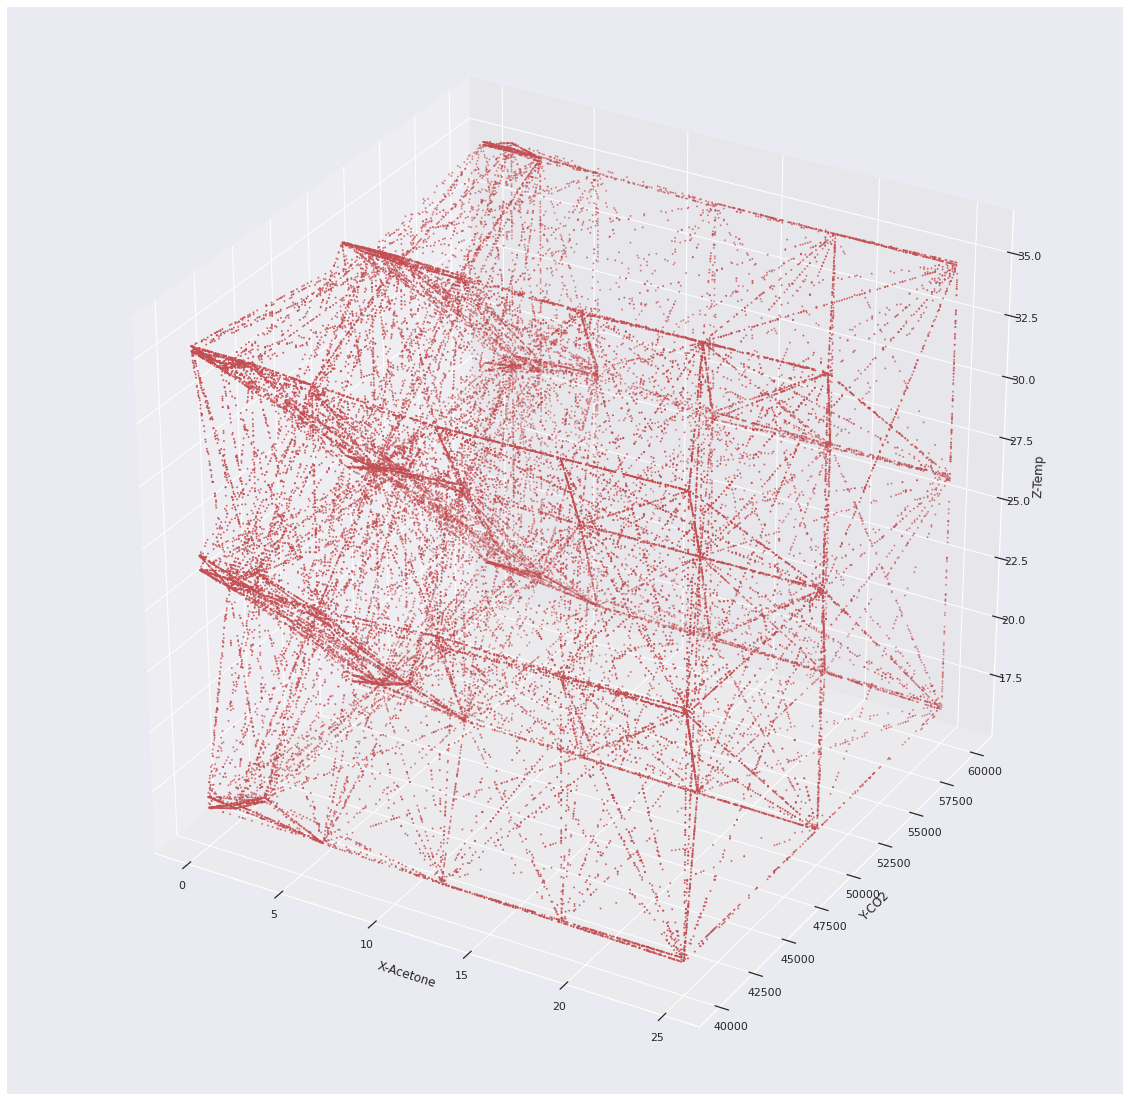

In [ ]:
X= db['Acetone']
Y =db['CO2']
Z =db['Instr_Temp']

# plot points and fitted surface
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')
#ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(X, Y, Z, c='r', s=1)
plt.xlabel('X-Acetone')
plt.ylabel('Y-CO2')
ax.set_zlabel('Z-Temp')
ax.axis('tight')
plt.show()